In [1]:
import pandas as pd
import numpy as np

In [2]:
purchases_vendor = pd.read_csv('../data/preprocessed/purchases_vendor.csv')
purchase_prices=pd.read_csv('../data/preprocessed/purchase_prices.csv')
inventory=pd.read_csv('../data/preprocessed/inventory.csv')
eom_inventory=pd.read_csv('../data/preprocessed/eom_inventory_data.csv')
sales_old =pd.read_csv('../data/preprocessed/sales_profit.csv')
list_402 = pd.read_csv('../data/preprocessed/brand_category_analysis.csv')
sales = pd.read_csv('../data/preprocessed/sales_fifo.csv')

In [3]:
sales1 = sales
### 1️⃣ 날짜형 컬럼 변환
sales1['fifo_receiving_date'] = pd.to_datetime(sales1['fifo_receiving_date'], errors='coerce')
sales1['sales_date'] = pd.to_datetime(sales1['sales_date'], errors='coerce')

### 2️⃣ 보유기간 계산 (일 단위)
sales1['hand_time'] = (sales1['sales_date'] - sales1['fifo_receiving_date']).dt.days

In [4]:
# 1️⃣ 날짜형 컬럼 변환
sales1['fifo_receiving_date'] = pd.to_datetime(sales1['fifo_receiving_date'], errors='coerce')
sales1['fifo_purchase_order_date'] = pd.to_datetime(sales1['fifo_purchase_order_date'], errors='coerce')

# 2️⃣ 리드타임 계산 (일 단위)
sales1['lead_time'] = (sales1['fifo_receiving_date'] - sales1['fifo_purchase_order_date']).dt.days

In [5]:
sales1.head()

,inventory_id,sales_quantity,sales_dollars,sales_price,sales_date,excise_tax,vendor_id,month,dayofweek,volume,...,fifo_purchase_cost,fifo_purchase_order_date,fifo_receiving_date,fifo_invoice_date,is_shortage,fifo_is_opening,gross_profit,gross_margin_rate,hand_time,lead_time
0,1_SPARROW_1004,1,16.49,16.49,2024-01-01,0.79,12546,1,0,750.0,...,10.65,NaT,NaT,NaN,False,True,5.05,0.306246,NaN,NaN
1,1_SPARROW_1004,2,32.98,16.49,2024-01-02,1.57,12546,1,1,750.0,...,10.65,NaT,NaT,NaN,False,True,10.11,0.306549,NaN,NaN
2,1_SPARROW_1004,1,16.49,16.49,2024-01-03,0.79,12546,1,2,750.0,...,10.65,NaT,NaT,NaN,False,True,5.05,0.306246,NaN,NaN
3,1_SPARROW_1004,1,14.49,14.49,2024-01-08,0.79,12546,1,0,750.0,...,10.65,NaT,NaT,NaN,False,True,3.05,0.210490,NaN,NaN
4,1_SPARROW_1005,2,69.98,34.99,2024-01-09,0.79,12546,1,1,750.0,...,27.34,NaT,NaT,NaN,False,True,14.51,0.207345,NaN,NaN


In [6]:
# 2. 분석 대상 brand_id 목록 추출
target_brand_ids = list_402['brand_id'].unique()
sales1['store_id'] = sales_old['store_id'].values
sales1['brand_id'] = sales_old['brand_id'].values
# 2️⃣ sales에서 해당 brand_id만 필터링
sales1 = sales1[sales1['brand_id'].isin(target_brand_ids)]

In [7]:
# brand_id × sales_date 기준으로 평균 lead_time 계산
avg_lead_by_brand = (
    sales1.groupby(['brand_id', 'sales_date'])['lead_time']
    .mean()
    .reset_index()
    .rename(columns={'lead_time': 'avg_lead_time'})
)
avg_lead_by_brand

,brand_id,sales_date,avg_lead_time
0,126,2024-01-01,NaN
1,126,2024-01-02,NaN
2,126,2024-01-03,12.000000
3,126,2024-01-04,13.000000
4,126,2024-01-05,12.000000
...,...,...,...
138261,46447,2024-12-27,7.000000
138262,46447,2024-12-28,7.750000
138263,46447,2024-12-29,7.705882
138264,46447,2024-12-30,7.107143


In [8]:
### brand_id × sales_date 기준으로 평균 hand_time 계산
avg_hand_by_brand = (
    sales1.groupby(['brand_id', 'sales_date'])['hand_time']
    .mean()
    .reset_index()
    .rename(columns={'hand_time': 'avg_hand_time'})
)
avg_hand_by_brand

,brand_id,sales_date,avg_hand_time
0,126,2024-01-01,NaN
1,126,2024-01-02,NaN
2,126,2024-01-03,2.000000
3,126,2024-01-04,2.000000
4,126,2024-01-05,4.000000
...,...,...,...
138261,46447,2024-12-27,23.615385
138262,46447,2024-12-28,57.928571
138263,46447,2024-12-29,42.411765
138264,46447,2024-12-30,41.035714


In [9]:
# 2. 분석 대상 brand_id 목록 추출
target_brand_ids = list_402['brand_id'].unique()

# 3. sales 데이터프레임에서 대상 brand_id의 판매 기록만 필터링
sales_filtered = sales[sales['brand_id'].isin(target_brand_ids)].copy()

# 4. 일별, 매장별, 브랜드별 판매량 집계 (sum)
# 동일한 날짜, 매장, 브랜드에 여러 판매 기록이 있을 수 있으므로 sum()을 사용합니다.
daily_sales_agg = sales_filtered.groupby(
    ['store_id', 'brand_id', 'sales_date']
)['sales_quantity'].sum().reset_index()

# 5. list_402에서 'brand_id'와 'category' 정보만 추출 (매핑 테이블 생성)
# 중복이 있을 수 있으므로 .drop_duplicates()를 사용해 고유한 매핑을 보장합니다.
brand_category_map = list_402[['brand_id', 'category']].drop_duplicates()

# 6. 집계된 판매량 데이터에 카테고리 정보 병합(merge)
final_data = pd.merge(
    daily_sales_agg,
    brand_category_map,
    on='brand_id',
    how='left'  # 판매 기록(왼쪽)을 기준으로 카테고리 정보(오른쪽)를 붙입니다.
)

# 7. 요청하신 칼럼명으로 변경 및 순서 정렬
final_data_renamed = final_data.rename(columns={
    'sales_date': '날짜',
    'sales_quantity': '판매량',
    'category': '술 카테고리'
})

# 최종 결과 데이터프레임 (요청하신 칼럼 순서)
daily_sales_by_brand = final_data_renamed[
    ['store_id', 'brand_id', '날짜', '판매량', '술 카테고리']
]

# 결과 확인
print("생성된 일별 판매량 데이터 (상위 5개):")
print(daily_sales_by_brand.head())

print(f"\n총 {len(daily_sales_by_brand)}개의 일별 판매 기록이 생성되었습니다.")


# --- 1. 날짜 데이터 변환 (필수) ---
# 모든 날짜 칼럼을 datetime 객체로 변환하여 비교/병합이 가능하도록 합니다.
print("1. 날짜 데이터 변환 중...")
try:
    sales['sales_date'] = pd.to_datetime(sales['sales_date'])
    purchases_vendor['receiving_date'] = pd.to_datetime(purchases_vendor['receiving_date'])
    inventory['begin_date'] = pd.to_datetime(inventory['begin_date'])
    inventory['end_date'] = pd.to_datetime(inventory['end_date'])
except Exception as e:
    print(f"날짜 변환 오류: {e}. 날짜 형식을 확인해주세요. (예: YYYY-MM-DD)")
    # 오류 발생 시 중단
    exit()

# --- 2. 핵심 데이터 준비 ---
print("2. 분석 대상 데이터 준비 중...")
# 분석 대상 402개 brand_id
target_brand_ids = list_402['brand_id'].unique()

# brand_id와 카테고리 매핑 테이블
brand_category_map = list_402[['brand_id', 'category']].drop_duplicates()
brand_category_map = brand_category_map.rename(columns={'category': '술 카테고리'})

# 모든 데이터를 402개 브랜드 기준으로 필터링
sales_filtered = sales[sales['brand_id'].isin(target_brand_ids)]
purch_filtered = purchases_vendor[purchases_vendor['brand_id'].isin(target_brand_ids)]
inv_filtered = inventory[inventory['brand_id'].isin(target_brand_ids)]

# --- 3. 일별 거래량 집계 ---
print("3. 일별 판매/매입량 집계 중...")
# 일별/매장별/브랜드별 판매량
daily_sales_agg = sales_filtered.groupby(
    ['store_id', 'brand_id', 'sales_date']
)['sales_quantity'].sum().reset_index().rename(
    columns={'sales_date': '날짜', 'sales_quantity': '판매량'}
)

# 일별/매장별/브랜드별 매입량
daily_purch_agg = purch_filtered.groupby(
    ['store_id', 'brand_id', 'receiving_date']
)['quantity'].sum().reset_index().rename(
    columns={'receiving_date': '날짜', 'quantity': '매입량'}
)

# --- 4. 초기 재고 데이터 준비 ---
print("4. 초기 재고 데이터 준비 중...")
# (store_id, brand_id) 별로 가장 이른 'begin_date'의 'on_hand_begin' 값을 기초 재고로 사용
initial_stock = inv_filtered.sort_values('begin_date').drop_duplicates(
    subset=['store_id', 'brand_id']
)[['store_id', 'brand_id', 'on_hand_begin']]

# --- 5. 마스터 데이터 그리드 생성 ---
# (모든 날짜) x (모든 store_id, brand_id 조합)
print("5. 마스터 데이터 그리드 생성 중...")

# 5a. 전체 기간 설정
min_date = min(daily_sales_agg['날짜'].min(), daily_purch_agg['날짜'].min(), inv_filtered['begin_date'].min())
max_date = max(daily_sales_agg['날짜'].max(), daily_purch_agg['날짜'].max(), inv_filtered['end_date'].max())
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# 5b. (store_id, brand_id) 고유 조합
all_pairs = pd.concat([
    daily_sales_agg[['store_id', 'brand_id']],
    daily_purch_agg[['store_id', 'brand_id']],
    initial_stock[['store_id', 'brand_id']]
]).drop_duplicates()

# 5c. Cross Join으로 (store, brand, date) 그리드 생성
base_grid = all_pairs.assign(key=1).merge(
    pd.DataFrame({'날짜': all_dates, 'key': 1}), on='key'
).drop('key', axis=1)

print(f"   (그리드 크기: {len(base_grid)} 행)")

# --- 6. 데이터 병합 ---
print("6. 판매/매입 데이터 병합 중...")
# 그리드에 일별 판매량 병합
data = pd.merge(base_grid, daily_sales_agg, on=['store_id', 'brand_id', '날짜'], how='left')
# 그리드에 일별 매입량 병합
data = pd.merge(data, daily_purch_agg, on=['store_id', 'brand_id', '날짜'], how='left')

# NaN (거래 없는 날)을 0으로 채움
data[['판매량', '매입량']] = data[['판매량', '매입량']].fillna(0)

# --- 7. 일별 재고 계산 (Cumulative Sum) ---
print("7. 누적 재고 계산 중...")
# 계산을 위해 (store_id, brand_id)로 그룹화하고 날짜순 정렬
data.sort_values(by=['store_id', 'brand_id', '날짜'], inplace=True)

# 일별 순 재고 변동 (매입 - 판매)
data['net_flow'] = data['매입량'] - data['판매량']

# (store_id, brand_id) 그룹별로 누적 변동량 계산
data['cumulative_flow'] = data.groupby(['store_id', 'brand_id'])['net_flow'].cumsum()

# 초기 재고 데이터 병합
data = pd.merge(data, initial_stock, on=['store_id', 'brand_id'], how='left')
data['on_hand_begin'].fillna(0, inplace=True) # 초기 재고 기록이 없으면 0으로 시작

# 최종 재고 = 초기 재고 + 누적 변동량
data['남은 재고'] = data['on_hand_begin'] + data['cumulative_flow']

# --- 8. 최종 데이터프레임 생성 ---
print("8. 최종 데이터프레임 정리 중...")
# 카테고리 정보 병합
final_daily_inventory = pd.merge(data, brand_category_map, on='brand_id', how='left')

# 요청한 칼럼 선택 (날짜 포함)
final_daily_inventory = final_daily_inventory[
    ['store_id', 'brand_id', '날짜', '남은 재고', '판매량', '매입량', '술 카테고리']
]

# 결과 확인
print("\n--- 생성된 일별 재고 데이터 (상위 10개) ---")
print(final_daily_inventory.head(10))

print(f"\n총 {len(final_daily_inventory)}개의 일별 재고 기록이 생성되었습니다.")

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler


# 날짜 칼럼을 datetime으로 변환 (파일 로드 시 문자열로 로드되기 때문)
daily_sales_by_brand['날짜'] = pd.to_datetime(daily_sales_by_brand['날짜'])
final_daily_inventory['날짜'] = pd.to_datetime(final_daily_inventory['날짜'])


# --- 1단계: 독립변수 준비 (Static Variables) ---

# 1. 가격 (X1): brand_id별 평균 'sales_price'
# brand_id별로 유의미한 가격 변동이 없다면 평균값을 사용
avg_price = sales.groupby('brand_id')['sales_price'].mean().reset_index()
avg_price = avg_price.rename(columns={'sales_price': 'avg_price'})

# 5. 제품 카테고리 (X5)
category_map = list_402[['brand_id', 'category']].drop_duplicates()


# --- 2단계: 시계열 데이터 집계 (Brand_id별) ---
# store_id를 제외하고 brand_id와 날짜 기준으로 데이터를 합칩니다.

print("brand_id별 일별 데이터 집계 중...")
# 일별 총 판매량 (Y)
daily_sales_agg = daily_sales_by_brand.groupby(
    ['brand_id', '날짜']
)['판매량'].sum().reset_index()

# 일별 총 재고량 (X3의 기반)
daily_inventory_agg = final_daily_inventory.groupby(
    ['brand_id', '날짜']
)['남은 재고'].sum().reset_index()


# --- 3단계: 피처 엔지니어링 (Lagged Variables) ---
# Y(당일 판매량)를 예측하기 위해 X(이전 일 데이터)를 사용합니다.

print("Lagged 변수 (이전 일 판매량/재고) 생성 중...")
# 데이터를 brand_id, 날짜 순으로 정렬
daily_sales_agg.sort_values(by=['brand_id', '날짜'], inplace=True)
daily_inventory_agg.sort_values(by=['brand_id', '날짜'], inplace=True)

# 4. 이전 일 판매량 (X4)
# groupb_id별로 1일씩 데이터를 뒤로 미룸(shift)
daily_sales_agg['prev_day_sales'] = daily_sales_agg.groupby('brand_id')['판매량'].shift(1)

# 3. 이전 일 재고량 (X3)
# 오늘 판매량에 영향을 미치는 것은 '오늘의 기초 재고' = '어제의 기말 재고'
daily_inventory_agg['prev_day_inventory'] = daily_inventory_agg.groupby('brand_id')['남은 재고'].shift(1)


# --- 4단계: 최종 모델링 데이터셋 구축 ---
print("모든 변수 병합 중...")

# 1. 기본 데이터 (Y: 판매량, X4: 이전 일 판매량)
model_data = daily_sales_agg.copy()

# 2. (X3: 이전 일 재고량) 병합
model_data = pd.merge(
    model_data,
    daily_inventory_agg[['brand_id', '날짜', 'prev_day_inventory']],
    on=['brand_id', '날짜'],
    how='left'
)

# 3. (X1: 평균 가격) 병합
model_data = pd.merge(
    model_data,
    avg_price,
    on='brand_id',
    how='left'
)

# 4. (X5: 카테고리) 병합
model_data = pd.merge(
    model_data,
    category_map,
    on='brand_id',
    how='left'
)

model_data

생성된 일별 판매량 데이터 (상위 5개):
   store_id  brand_id         날짜  판매량 술 카테고리
0         1       126 2024-01-09    2  Vodka
1         1       126 2024-01-11    1  Vodka
2         1       126 2024-01-14    3  Vodka
3         1       126 2024-01-15    2  Vodka
4         1       126 2024-01-20    1  Vodka

총 3399191개의 일별 판매 기록이 생성되었습니다.
1. 날짜 데이터 변환 중...
2. 분석 대상 데이터 준비 중...
3. 일별 판매/매입량 집계 중...
4. 초기 재고 데이터 준비 중...
5. 마스터 데이터 그리드 생성 중...
   (그리드 크기: 11161902 행)
6. 판매/매입 데이터 병합 중...
7. 누적 재고 계산 중...


C:\Users\user\AppData\Local\Temp\ipykernel_7992\451787254.py:140: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['on_hand_begin'].fillna(0, inplace=True) # 초기 재고 기록이 없으면 0으로 시작


8. 최종 데이터프레임 정리 중...

--- 생성된 일별 재고 데이터 (상위 10개) ---
   store_id  brand_id         날짜  남은 재고  판매량   매입량 술 카테고리
0         1       126 2024-01-01   29.0  0.0  12.0  Vodka
1         1       126 2024-01-02   29.0  0.0   0.0  Vodka
2         1       126 2024-01-03   29.0  0.0   0.0  Vodka
3         1       126 2024-01-04   41.0  0.0  12.0  Vodka
4         1       126 2024-01-05   41.0  0.0   0.0  Vodka
5         1       126 2024-01-06   41.0  0.0   0.0  Vodka
6         1       126 2024-01-07   41.0  0.0   0.0  Vodka
7         1       126 2024-01-08   41.0  0.0   0.0  Vodka
8         1       126 2024-01-09   39.0  2.0   0.0  Vodka
9         1       126 2024-01-10   39.0  0.0   0.0  Vodka

총 11161902개의 일별 재고 기록이 생성되었습니다.
brand_id별 일별 데이터 집계 중...
Lagged 변수 (이전 일 판매량/재고) 생성 중...
모든 변수 병합 중...


,brand_id,날짜,판매량,prev_day_sales,prev_day_inventory,avg_price,category
0,126,2024-01-01,64,NaN,NaN,31.113056,Vodka
1,126,2024-01-02,213,64.0,2566.0,31.113056,Vodka
2,126,2024-01-03,99,213.0,2407.0,31.113056,Vodka
3,126,2024-01-04,14,99.0,2308.0,31.113056,Vodka
4,126,2024-01-05,20,14.0,2469.0,31.113056,Vodka
...,...,...,...,...,...,...,...
138261,46447,2024-12-27,35,31.0,1388.0,11.110448,Wine
138262,46447,2024-12-28,57,35.0,1481.0,11.110448,Wine
138263,46447,2024-12-29,24,57.0,1582.0,11.110448,Wine
138264,46447,2024-12-30,59,24.0,1593.0,11.110448,Wine


In [10]:
# 1️⃣ 컬럼명 통일 (sales_date ↔ 날짜)
avg_hand_by_brand = avg_hand_by_brand.rename(columns={'sales_date': '날짜'})

# 두 데이터 모두 datetime 형식으로 통일
model_data['날짜'] = pd.to_datetime(model_data['날짜'])
avg_hand_by_brand['날짜'] = pd.to_datetime(avg_hand_by_brand['날짜'])

merged_model = model_data.merge(
    avg_hand_by_brand,
    on=['brand_id', '날짜'],
    how='left'
)

# 3️⃣ 확인
merged_model.head()

,brand_id,날짜,판매량,prev_day_sales,prev_day_inventory,avg_price,category,avg_hand_time
0,126,2024-01-01,64,NaN,NaN,31.113056,Vodka,NaN
1,126,2024-01-02,213,64.0,2566.0,31.113056,Vodka,NaN
2,126,2024-01-03,99,213.0,2407.0,31.113056,Vodka,2.0
3,126,2024-01-04,14,99.0,2308.0,31.113056,Vodka,2.0
4,126,2024-01-05,20,14.0,2469.0,31.113056,Vodka,4.0


In [11]:
# 1️⃣ 컬럼명 통일 (sales_date ↔ 날짜)
avg_lead_by_brand

,brand_id,sales_date,avg_lead_time
0,126,2024-01-01,NaN
1,126,2024-01-02,NaN
2,126,2024-01-03,12.000000
3,126,2024-01-04,13.000000
4,126,2024-01-05,12.000000
...,...,...,...
138261,46447,2024-12-27,7.000000
138262,46447,2024-12-28,7.750000
138263,46447,2024-12-29,7.705882
138264,46447,2024-12-30,7.107143


In [12]:
# 1️⃣ 컬럼명 통일 (sales_date ↔ 날짜)
avg_lead_by_brand = avg_lead_by_brand.rename(columns={'sales_date': '날짜'})

# 두 데이터 모두 datetime 형식으로 통일
model_data['날짜'] = pd.to_datetime(model_data['날짜'])
avg_lead_by_brand['날짜'] = pd.to_datetime(avg_lead_by_brand['날짜'])

merged_model = pd.merge(merged_model, avg_lead_by_brand, on=['brand_id', '날짜'], how='left')
merged_model

,brand_id,날짜,판매량,prev_day_sales,prev_day_inventory,avg_price,category,avg_hand_time,avg_lead_time
0,126,2024-01-01,64,NaN,NaN,31.113056,Vodka,NaN,NaN
1,126,2024-01-02,213,64.0,2566.0,31.113056,Vodka,NaN,NaN
2,126,2024-01-03,99,213.0,2407.0,31.113056,Vodka,2.000000,12.000000
3,126,2024-01-04,14,99.0,2308.0,31.113056,Vodka,2.000000,13.000000
4,126,2024-01-05,20,14.0,2469.0,31.113056,Vodka,4.000000,12.000000
...,...,...,...,...,...,...,...,...,...
138261,46447,2024-12-27,35,31.0,1388.0,11.110448,Wine,23.615385,7.000000
138262,46447,2024-12-28,57,35.0,1481.0,11.110448,Wine,57.928571,7.750000
138263,46447,2024-12-29,24,57.0,1582.0,11.110448,Wine,42.411765,7.705882
138264,46447,2024-12-30,59,24.0,1593.0,11.110448,Wine,41.035714,7.107143


In [13]:
model_data = merged_model

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# --- 0단계: 데이터 준비 ---
model_data = model_data.copy()

# ✅ 날짜 형식 통일
model_data['날짜'] = pd.to_datetime(model_data['날짜'], errors='coerce')

# ✅ NaN 행 삭제
model_data = model_data.dropna(subset=[
    'avg_hand_time', 'prev_day_sales', 'prev_day_inventory', 'avg_price', '판매량'
])
print(f"NaN 제거 후 데이터 수: {len(model_data)}")

# --- 1단계: One-Hot Encoding ---
model_data_processed = pd.get_dummies(model_data, columns=['category'], drop_first=True)

# --- 2단계: 이상치 제거 (Z-score, 제곱근 변환, 0 유지) ---
print("\n이상치 제거 중... (Z-score 기반)")

outlier_features = ['prev_day_sales', 'prev_day_inventory', 'avg_price', '판매량']
before_total = len(model_data_processed)

for col in outlier_features:
    nonzero_mask = model_data_processed[col] > 0
    sqrt_col = np.sqrt(model_data_processed.loc[nonzero_mask, col])
    z_scores = np.abs(stats.zscore(sqrt_col))
    keep_mask = z_scores < 2.58
    filtered_idx = model_data_processed.loc[nonzero_mask].index[keep_mask]
    model_data_processed = model_data_processed.loc[
        filtered_idx.union(model_data_processed.index[~nonzero_mask])
    ].reset_index(drop=True)
    print(f"{col}: 남은 데이터 {len(model_data_processed)}개")

after_total = len(model_data_processed)
print(f"\n총 제거된 이상치 수: {before_total - after_total}개")

# --- 3단계: 종속변수 변환 ---
Y = np.sqrt(model_data_processed['판매량'])
feature_columns = [c for c in model_data_processed.columns if c not in ['brand_id', '날짜', '판매량']]
X = model_data_processed[feature_columns]

# --- 4단계: 시계열 분할 ---
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
Y_train, Y_test = Y.iloc[:split_index], Y.iloc[split_index:]
print(f"학습 데이터: {len(X_train)}, 테스트 데이터: {len(X_test)}")

# --- 5단계: 표준화 ---
continuous_features = ['prev_day_sales', 'prev_day_inventory', 'avg_price', 'avg_hand_time']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test_scaled = X_test.copy()
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])
print("\n[성공] StandardScaler로 숫자형 변수 표준화 완료")

# --- 6단계: VIF 계산 ---
vif_data = pd.DataFrame({
    "feature": X_train_scaled.columns,
    "VIF": [variance_inflation_factor(X_train_scaled.astype(float).values, i)
            for i in range(X_train_scaled.shape[1])]
})
print("\n--- [ 스케일링 후 VIF 계산 ] ---")
print(vif_data)

# --- 7단계: OLS 회귀 ---
X_train_sm = sm.add_constant(X_train_scaled, has_constant='add').astype(float)
X_test_sm = sm.add_constant(X_test_scaled, has_constant='add').astype(float)
model = sm.OLS(Y_train, X_train_sm)
results = model.fit()

print("\n--- [ OLS 회귀 결과 요약 (제곱근 변환된 판매량) ] ---")
print(results.summary())

# --- 8단계: 테스트셋 성능 ---
Y_pred_sqrt = results.predict(X_test_sm)
Y_pred = Y_pred_sqrt**2  # 역변환
Y_test_real = Y_test**2

rmse = np.sqrt(mean_squared_error(Y_test_real, Y_pred))
r2 = r2_score(Y_test_real, Y_pred)
print("\n--- [ 테스트 데이터 성능 평가 (역변환 후) ] ---")
print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

# --- 9단계: 회귀 계수 ---
print("\n--- [ 변수별 회귀 계수 (제곱근 단위) ] ---")
print(results.params)

NaN 제거 후 데이터 수: 130044

이상치 제거 중... (Z-score 기반)
prev_day_sales: 남은 데이터 126739개
prev_day_inventory: 남은 데이터 124524개
avg_price: 남은 데이터 122545개
판매량: 남은 데이터 120111개

총 제거된 이상치 수: 9933개
학습 데이터: 96088, 테스트 데이터: 24023

[성공] StandardScaler로 숫자형 변수 표준화 완료

--- [ 스케일링 후 VIF 계산 ] ---
               feature        VIF
0       prev_day_sales   1.648377
1   prev_day_inventory   1.620745
2            avg_price   1.164235
3        avg_hand_time   1.133652
4        avg_lead_time  34.987858
5         category_Gin   1.928743
6     category_Liqueur   4.776644
7         category_Rum   3.381150
8     category_Tequila   1.954396
9       category_Vodka   6.418312
10    category_Whiskey   5.391694
11       category_Wine  17.433041

--- [ OLS 회귀 결과 요약 (제곱근 변환된 판매량) ] ---
                            OLS Regression Results                            
Dep. Variable:                    판매량   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:

데이터가 너무 많아 10000개만 샘플링하여 시각화합니다.
--- 1 & 3. 선형성/등분산성 (샘플 데이터) ---


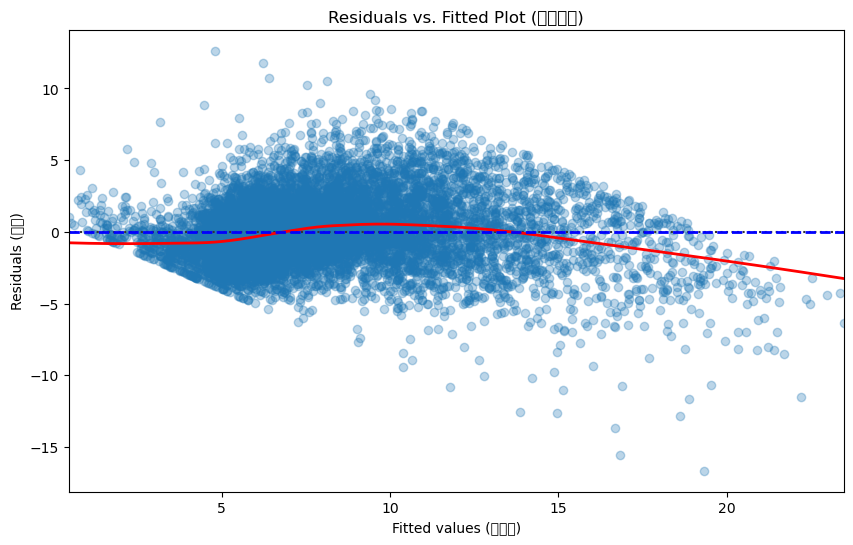


--- 2. 오차의 정규성 (샘플 데이터) ---


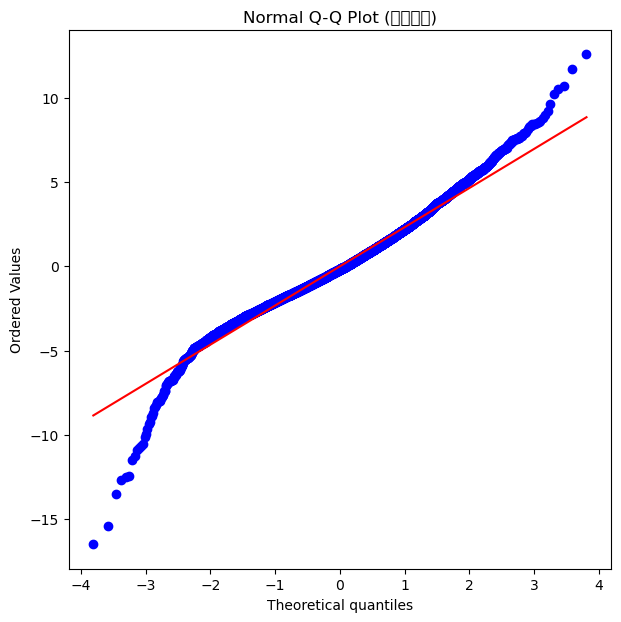


--- 4. 오차의 독립성 (Durbin-Watson) ---
Durbin-Watson Statistic: 1.547

--- 5. 다중공선성 (VIF) ---
               feature        VIF
0       prev_day_sales   1.648377
1   prev_day_inventory   1.620745
2            avg_price   1.164235
3        avg_hand_time   1.133652
4        avg_lead_time  34.987858
5         category_Gin   1.928743
6     category_Liqueur   4.776644
7         category_Rum   3.381150
8     category_Tequila   1.954396
9       category_Vodka   6.418312
10    category_Whiskey   5.391694
11       category_Wine  17.433041


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# (이전에 model = sm.OLS(...) / results = model.fit()이 완료되었다고 가정)

# --- [수정] 샘플링을 위한 데이터 준비 ---
residuals = results.resid
predicted_values = results.predict(X_train_sm)
X_train_for_vif = X_train_scaled.copy() # VIF 계산용 (전체 데이터)

# 1. 샘플 크기 지정
sample_size = 10000  # 5000개 ~ 10000개 사이로 조절

# 2. 데이터가 샘플 크기보다 클 경우에만 샘플링
if len(residuals) > sample_size:
    print(f"데이터가 너무 많아 {sample_size}개만 샘플링하여 시각화합니다.")
    # 무작위로 샘플 인덱스 추출
    sample_indices = np.random.choice(len(residuals), sample_size, replace=False)
    
    # 샘플 데이터 생성
    residuals_sample = residuals.iloc[sample_indices]
    predicted_values_sample = predicted_values.iloc[sample_indices]
else:
    # 데이터가 적으면 그냥 전체 사용
    residuals_sample = residuals
    predicted_values_sample = predicted_values

# --- 1. 선형성 & 3. 등분산성 (샘플 데이터 사용) ---
print("--- 1 & 3. 선형성/등분산성 (샘플 데이터) ---")
plt.figure(figsize=(10, 6))
# ★★★ lowess=True를 유지하되, 샘플링된 데이터(predicted_values_sample)를 사용
sns.residplot(x=predicted_values_sample, y=residuals_sample, lowess=True, 
              scatter_kws={'alpha': 0.3}, 
              line_kws={'color': 'red', 'lw': 2})
plt.title('Residuals vs. Fitted Plot (샘플링됨)')
plt.xlabel('Fitted values (예측값)')
plt.ylabel('Residuals (잔차)')
plt.axhline(y=0, color='blue', linestyle='--', lw=2)
plt.show()


# --- 2. 오차의 정규성 (샘플 데이터 사용) ---
print("\n--- 2. 오차의 정규성 (샘플 데이터) ---")
plt.figure(figsize=(7, 7))
# ★★★ 샘플링된 잔차(residuals_sample)를 사용
stats.probplot(residuals_sample, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot (샘플링됨)')
plt.show()


# --- 4. 오차의 독립성 (전체 데이터 - 빠름) ---
from statsmodels.stats.stattools import durbin_watson
print("\n--- 4. 오차의 독립성 (Durbin-Watson) ---")
dw_statistic = durbin_watson(results.resid)
print(f"Durbin-Watson Statistic: {float(dw_statistic):.3f}")


# --- 5. 다중공선성 (전체 데이터 - 빠름) ---
print("\n--- 5. 다중공선성 (VIF) ---")
# ★★★ VIF는 통계 계산이므로 샘플링이 아닌 '전체 X 데이터'를 사용해야 함
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_for_vif.astype(float).values, i) 
                   for i in range(X_train_for_vif.shape[1])]
print(vif_data)

In [16]:
daily_sales_by_brand = pd.read_csv('../data/preprocessed/daily_sales_by_brand_id.csv')

In [18]:
import pandas as pd

# --- 1. 데이터 준비 ---
# (노트북 환경에서 daily_sales_by_brand 가 존재한다고 가정)
# daily_sales_by_brand: store_id, brand_id, 날짜, 판매량, 술 카테고리

# 1a. 날짜 칼럼을 datetime 객체로 변환 (아직 안 되어 있다면)
try:
    daily_sales_by_brand['날짜'] = pd.to_datetime(daily_sales_by_brand['날짜'])
    print("날짜 칼럼 변환 완료.")
except KeyError:
    print("Error: 'daily_sales_by_brand' 데이터프레임 또는 '날짜' 칼럼을 찾을 수 없습니다.")
    # 임시 데이터 (실행 위해)
    daily_sales_by_brand = pd.DataFrame({
        '날짜': pd.to_datetime(['2024-01-15', '2024-01-20', '2024-02-10', '2024-02-15', '2024-06-05', '2024-06-10', '2024-12-20', '2024-12-25']),
        '판매량': [10, 15, 20, 25, 5, 50, 30, 60],
        'store_id': [1]*8, 'brand_id': [126]*8, '술 카테고리': ['Vodka']*8
    })
    print("임시 데이터로 실행합니다.")


# --- 2. 월별 변동성 계산 ---

# 2a. '월' 칼럼 생성 (1월=1, 2월=2, ...)
daily_sales_by_brand['월'] = daily_sales_by_brand['날짜'].dt.month

# 2b. 월별 일일 판매량의 표준편차 계산
# std() 함수는 기본적으로 표본 표준편차(N-1로 나눔)를 계산합니다.
monthly_volatility = daily_sales_by_brand.groupby('월')['판매량'].std().reset_index()
monthly_volatility = monthly_volatility.rename(columns={'판매량': '일별_판매량_표준편차'})

# 2c. (선택) 월별 일일 판매량의 분산 계산 (표준편차의 제곱)
# monthly_volatility_var = daily_sales_by_brand.groupby('월')['판매량'].var().reset_index()
# monthly_volatility_var = monthly_volatility_var.rename(columns={'판매량': '일별_판매량_분산'})


# --- 3. 결과 정렬 및 출력 ---

# 표준편차가 높은 순 (내림차순)으로 정렬
monthly_volatility_sorted = monthly_volatility.sort_values(by='일별_판매량_표준편차', ascending=False)

print("\n" + "="*50)
print("--- [ 월별 판매량 변동성 (일별 판매량 표준편차 기준) ] ---")
print("   (표준편차가 클수록 해당 월의 일별 판매량 변동이 심함을 의미)")
print(monthly_volatility_sorted.to_string(index=False, float_format='%.2f'))
print("="*50)

# --- 4. 가설 검증 (참고) ---
high_volatility_months = monthly_volatility_sorted.head(5)['월'].tolist() # 상위 5개 월 추출
hypothesized_months = [6, 7, 8, 11, 12]

print("\n--- [ 가설 참고 ] ---")
print(f"가설 성수기 월: {hypothesized_months}")
print(f"변동성 상위 5개 월: {high_volatility_months}")

날짜 칼럼 변환 완료.

--- [ 월별 판매량 변동성 (일별 판매량 표준편차 기준) ] ---
   (표준편차가 클수록 해당 월의 일별 판매량 변동이 심함을 의미)
 월  일별_판매량_표준편차
 7        11.01
11         9.43
12         8.00
 6         7.41
 9         6.45
 5         6.35
 8         6.34
10         5.94
 4         5.79
 2         5.33
 3         5.11
 1         5.01

--- [ 가설 참고 ] ---
가설 성수기 월: [6, 7, 8, 11, 12]
변동성 상위 5개 월: [7, 11, 12, 6, 9]


In [19]:
import pandas as pd

# --- 2. 데이터 필터링 ---

# 2a. 분석 대상 brand_id 목록 추출
target_brand_ids = list_402['brand_id'].unique()

# 2b. sales 데이터에서 대상 brand_id만 필터링
sales_filtered = sales[sales['brand_id'].isin(target_brand_ids)].copy()

# 2c. sales_date를 datetime으로 변환 (월 추출 위해 필수)
try:
    sales_filtered['sales_date'] = pd.to_datetime(sales_filtered['sales_date'])
except Exception as e:
    print(f"\n[오류] 'sales_date' 변환 실패: {e}. 날짜 형식을 확인해주세요.")
    exit()

# 2d. '월' 칼럼 생성
sales_filtered['월'] = sales_filtered['sales_date'].dt.month

# 2e. 대상 월(6, 7, 11, 12월) 데이터만 필터링
target_months = [6, 7, 11, 12]
sales_target_months = sales_filtered[sales_filtered['월'].isin(target_months)]

# --- 3. Store ID별 변동성 계산 ---
print("Store ID별 판매량 변동성(표준편차) 계산 중...")

# store_id 별로 그룹화하여 일별 판매량('sales_quantity')의 표준편차 계산
store_volatility = sales_target_months.groupby('store_id')['sales_quantity'].std().reset_index()
store_volatility = store_volatility.rename(columns={'sales_quantity': '일별_판매량_표준편차'})

# NaN 값 처리 (해당 월에 판매 기록이 1건뿐인 경우 std가 NaN이 됨) -> 0으로 대체
store_volatility['일별_판매량_표준편차'] = store_volatility['일별_판매량_표준편차'].fillna(0)

# --- 4. 결과 정렬 및 출력 ---

# 표준편차가 높은 순 (내림차순)으로 정렬
store_volatility_sorted = store_volatility.sort_values(by='일별_판매량_표준편차', ascending=False)

print("\n" + "="*50)
print("--- [ 6, 7, 11, 12월 판매량 변동성이 큰 Store ID ] ---")
print("   (일별 판매량 표준편차 기준, 상위 10개)")
print(store_volatility_sorted.head(10).to_string(index=False, float_format='%.2f'))
print("="*50)

Store ID별 판매량 변동성(표준편차) 계산 중...

--- [ 6, 7, 11, 12월 판매량 변동성이 큰 Store ID ] ---
   (일별 판매량 표준편차 기준, 상위 10개)
 store_id  일별_판매량_표준편차
       61        17.22
       74        16.94
       27        16.93
       50        16.86
       76        16.19
       32        16.07
       33        15.50
       73        15.45
       69        13.63
       34        13.57


In [22]:

# 확인할 store_id 목록
target_store_ids = [61, 74, 27, 50, 76, 32, 33, 73, 69, 34]

# 해당 store_id만 필터링
filtered_inventory = inventory[inventory['store_id'].isin(target_store_ids)]

# store_id와 city 칼럼만 선택하고 중복 제거
store_city_info = filtered_inventory[['store_id', 'city']].drop_duplicates()

# 결과 출력
print("\n--- [ Store ID별 City 정보 ] ---")
print(store_city_info.to_string(index=False))


--- [ Store ID별 City 정보 ] ---
 store_id    city
       27 Penguin
       32 Penguin
       33  Pigeon
       34  Puffin
       50 Penguin
       61  Shrike
       69 Penguin
       73  Hoopoe
       74    Kite
       76  Hoopoe


In [23]:
Hoopoe=inventory.loc[inventory['city']=='Hoopoe']

In [24]:
Hoopoe['store_id'].unique()

array([73, 76], dtype=int64)

In [25]:
sales1.head()

,inventory_id,sales_quantity,sales_dollars,sales_price,sales_date,excise_tax,vendor_id,month,dayofweek,volume,...,fifo_receiving_date,fifo_invoice_date,is_shortage,fifo_is_opening,gross_profit,gross_margin_rate,hand_time,lead_time,store_id,brand_id
8,1_SPARROW_10058,4,59.96,14.99,2024-01-05,0.45,2000,1,4,750.0,...,NaT,NaN,False,True,22.47,0.374750,NaN,NaN,1,10058
9,1_SPARROW_10058,1,14.99,14.99,2024-01-06,0.11,2000,1,5,750.0,...,NaT,NaN,False,True,5.62,0.374917,NaN,NaN,1,10058
10,1_SPARROW_10058,1,14.99,14.99,2024-01-08,0.11,2000,1,0,750.0,...,NaT,NaN,False,True,5.62,0.374917,NaN,NaN,1,10058
11,1_SPARROW_10058,1,14.99,14.99,2024-01-10,0.11,2000,1,2,750.0,...,NaT,NaN,False,True,5.62,0.374917,NaN,NaN,1,10058
12,1_SPARROW_10058,1,14.99,14.99,2024-01-19,0.11,2000,1,4,750.0,...,NaT,NaN,False,True,5.62,0.374917,NaN,NaN,1,10058


In [ ]:
import pandas as pd
import numpy as np

# --- 1. 데이터 준비 ---
# (Assumes sales1 and list_402 exist from your notebook '1029_보유기간_회귀3.ipynb')

# 1a. 분석 대상 brand_id 목록
try:
    target_brand_ids = list_402['brand_id'].unique()
except NameError:
    print("Warning: list_402 객체를 찾을 수 없습니다. 임시 데이터로 실행합니다.")
    list_402 = pd.DataFrame({'brand_id': [126, 273, 811]})
    target_brand_ids = list_402['brand_id'].unique()

# 1b. sales1 데이터 필터링 (store_id 61, 7월, 대상 brand_id)
try:
    # 날짜 타입 확인 및 '월' 칼럼 생성 (이미 되어있을 수 있음)
    if not pd.api.types.is_datetime64_any_dtype(sales1['sales_date']):
        sales1['sales_date'] = pd.to_datetime(sales1['sales_date'])
    if '월' not in sales1.columns:
        sales1['월'] = sales1['sales_date'].dt.month

    store_id_to_analyze = 61
    month_to_analyze = 7

    filtered_sales = sales1[
        (sales1['store_id'] == store_id_to_analyze) &
        (sales1['월'] == month_to_analyze) &
        (sales1['brand_id'].isin(target_brand_ids))
    ].copy()

    # 리드타임 NaN 값 제거 (통계 계산 전)
    filtered_sales.dropna(subset=['lead_time', 'sales_quantity'], inplace=True)
    # 음수 리드타임이 있다면 제거 (데이터 오류 가능성)
    filtered_sales = filtered_sales[filtered_sales['lead_time'] >= 0]


    print(f"Store ID {store_id_to_analyze}, {month_to_analyze}월 데이터 필터링 완료. (유효 데이터 {len(filtered_sales)}건)")

except NameError:
    print("Warning: sales1 객체를 찾을 수 없습니다. 임시 데이터로 실행합니다.")
    # 임시 데이터
    filtered_sales = pd.DataFrame({
        'brand_id': [126, 126, 126, 273, 273, 811, 811, 811, 811],
        'sales_date': pd.to_datetime(['2024-06-05', '2024-06-10', '2024-06-15', '2024-06-08', '2024-06-20', '2024-06-01', '2024-06-10', '2024-06-20', '2024-06-25']),
        'sales_quantity': [10, 15, 12, 5, 8, 20, 30, 25, 28],
        'lead_time': [7.0, 8.0, 7.0, 10.0, 9.0, 5.0, 6.0, 5.0, 6.0]
    })
    store_id_to_analyze = 61 # 임시 store_id
    month_to_analyze = 6 # 임시 월
except KeyError:
    print("Warning: sales1 객체에 필요한 칼럼('store_id', '월', 'brand_id', 'lead_time', 'sales_quantity')이 없습니다. 임시 데이터 사용.")
    # 임시 데이터 (위와 동일)
    filtered_sales = pd.DataFrame({
        'brand_id': [126, 126, 126, 273, 273, 811, 811, 811, 811],
        'sales_date': pd.to_datetime(['2024-06-05', '2024-06-10', '2024-06-15', '2024-06-08', '2024-06-20', '2024-06-01', '2024-06-10', '2024-06-20', '2024-06-25']),
        'sales_quantity': [10, 15, 12, 5, 8, 20, 30, 25, 28],
        'lead_time': [7.0, 8.0, 7.0, 10.0, 9.0, 5.0, 6.0, 5.0, 6.0]
    })
    store_id_to_analyze = 61
    month_to_analyze = 6

# --- 2. Brand ID별 통계 계산 (6월, Store 61 기준) ---
print("Brand ID별 리드타임 및 판매량 통계 계산 중...")

if filtered_sales.empty or len(filtered_sales) < 2: # 표준편차 계산을 위해 최소 2개 데이터 필요
    print(f"오류: Store ID {store_id_to_analyze}의 {month_to_analyze}월 데이터가 부족하여 ROP 계산 불가.")
else:
    # brand_id별 그룹화 및 통계 계산
    brand_stats_new = filtered_sales.groupby('brand_id').agg(
        # 평균 일 판매량 (수요량)
        D_avg=('sales_quantity', 'mean'),
        # 수요의 표준편차 (sigma_D)
        sigma_D=('sales_quantity', 'std'),
        # 평균 리드타임 (반올림 전)
        L_avg_raw=('lead_time', 'mean')
    ).reset_index()

    # 표준편차가 NaN인 경우(해당 brand 판매가 1건 뿐) 0으로 대체
    brand_stats_new['sigma_D'] = brand_stats_new['sigma_D'].fillna(0)

    # 평균 리드타임 반올림 (L)
    brand_stats_new['L'] = np.round(brand_stats_new['L_avg_raw']).astype(int)
    # 리드타임이 0일 경우 SS 계산 시 sqrt(0) 오류 방지 위해 최소 1로 설정 (선택적)
    brand_stats_new['L'] = brand_stats_new['L'].clip(lower=1)


    # NaN 값 처리 (데이터 부족 등으로 통계 계산이 안된 경우)
    brand_stats_new = brand_stats_new.fillna(0)


    # --- 3. ROP 및 주문량 계산 ---
    print("ROP 및 주문량 계산 중...")

    # 3a. Z 값 설정 (95% 서비스 수준)
    Z = 1.645

    # 3b. 안전 재고 (SS) = Z * sigma_D * sqrt(L)
    brand_stats_new['SS'] = Z * brand_stats_new['sigma_D'] * np.sqrt(brand_stats_new['L'])

    # 3c. 리드타임 동안의 예상 수요량 (LTD) = D_avg * L
    brand_stats_new['LTD'] = brand_stats_new['D_avg'] * brand_stats_new['L']

    # 3d. 재주문점 (ROP) = LTD + SS
    brand_stats_new['ROP'] = brand_stats_new['LTD'] + brand_stats_new['SS']

    # 3e. 주문량 (Order Quantity) = LTD + SS (사용자 정의)
    brand_stats_new['Order_Quantity'] = brand_stats_new['ROP']

    # --- 4. 최종 결과 출력 ---
    # 결과 확인에 필요한 칼럼 선택 및 소수점 처리 (반올림하여 정수로 표시)
    final_rop_eoq_new = brand_stats_new[[
        'brand_id',
        'L',             # 평균 리드타임 (반올림)
        'D_avg',         # 평균 일 판매량
        'sigma_D',       # 수요 표준편차
        'LTD',           # 리드타임 수요량
        'SS',            # 안전 재고
        'ROP',           # 재주문점
        'Order_Quantity' # 주문량
    ]].copy() # SettingWithCopyWarning 방지

    # 계산 결과 칼럼들을 정수로 반올림 (재고는 정수 단위로 관리되므로)
    cols_to_round = ['LTD', 'SS', 'ROP', 'Order_Quantity']
    for col in cols_to_round:
        final_rop_eoq_new[col] = np.round(final_rop_eoq_new[col]).astype(int)

    # ROP 높은 순 정렬
    final_rop_eoq_new.sort_values(by='ROP', ascending=False, inplace=True)

    print("\n" + "="*80)
    print(f"--- [ Store ID {store_id_to_analyze}, {month_to_analyze}월 Brand ID별 ROP 및 주문량 (통계적 SS 적용) ] ---")
    # 수요 표준편차만 소수점으로 표시하고 나머지는 정수로
    print(final_rop_eoq_new.to_string(index=False,
                                      formatters={'D_avg': '{:.2f}'.format, 'sigma_D': '{:.2f}'.format},
                                      col_space=12)) # 칼럼 간격 조정
    print("="*80)

Store ID 61, 7월 데이터 필터링 완료. (유효 데이터 3608건)
Brand ID별 리드타임 및 판매량 통계 계산 중...
ROP 및 주문량 계산 중...

--- [ Store ID 61, 7월 Brand ID별 ROP 및 주문량 (통계적 SS 적용) ] ---
    brand_id            L        D_avg      sigma_D          LTD           SS          ROP  Order_Quantity
        3851            8        88.69       208.66          710          971         1680            1680
        4245            7        47.86       114.83          335          500          835             835
       42188            7        69.56        50.25          487          219          706             706
        8068            7        45.25        71.59          317          312          628             628
         126            8        37.41        65.53          299          305          604             604
        3858            7        40.21        72.42          281          315          597             597
        8480            9        23.71        58.78          213          290          504       

In [30]:
daily_inventory_by_brand_id = pd.read_csv('../data/preprocessed/daily_inventory_by_brand_id.csv')

In [39]:
daily_inventory_by_brand_id.head()

,store_id,brand_id,날짜,남은 재고,판매량,매입량,술 카테고리
0,1,126,2024-01-01,29.0,0.0,12.0,Vodka
1,1,126,2024-01-02,29.0,0.0,0.0,Vodka
2,1,126,2024-01-03,29.0,0.0,0.0,Vodka
3,1,126,2024-01-04,41.0,0.0,12.0,Vodka
4,1,126,2024-01-05,41.0,0.0,0.0,Vodka


In [46]:
import pandas as pd
import numpy as np
from datetime import timedelta # 리드타임 계산을 위해 timedelta 임포트

# --- 1. 시뮬레이션 및 비교에 필요한 데이터 준비 ---
print("시뮬레이션 데이터 준비 중...")

# 1a. ROP/주문량/리드타임 데이터 (이전 단계에서 생성된 'final_rop_eoq_new' 사용)
try:
    if 'final_rop_eoq_new' not in locals():
         raise NameError("final_rop_eoq_new 객체를 찾을 수 없습니다. 이전 ROP 계산 셀을 실행해주세요.")
    # ROP, OQ, L_avg를 Dictionary 형태로 변환 (조회 용이)
    rop_dict = final_rop_eoq_new.set_index('brand_id')['ROP'].to_dict()
    oq_dict = final_rop_eoq_new.set_index('brand_id')['Order_Quantity'].to_dict()
    lead_time_dict = final_rop_eoq_new.set_index('brand_id')['L'].to_dict()
    target_brand_ids = final_rop_eoq_new['brand_id'].unique()
    print(f"ROP/주문량 데이터 확인. (대상 Brand: {len(target_brand_ids)}개)")
except NameError:
    print("Warning: final_rop_eoq_new 객체를 찾을 수 없습니다. 임시 ROP/OQ 데이터로 실행합니다.")
    # 임시 ROP/OQ/LT 데이터
    target_brand_ids = [126, 273]
    rop_dict = {126: 150, 273: 120}
    oq_dict = {126: 150, 273: 120}
    lead_time_dict = {126: 8, 273: 10}


# 1b. Brand ID별 평균 매입 단가
try:
    if 'purchase_prices' not in locals():
        raise NameError("purchase_prices not defined")
    avg_purchase_price = purchase_prices.groupby('brand_id')['purchase_price'].mean().reset_index()
    purchase_price_dict = avg_purchase_price.set_index('brand_id')['purchase_price'].to_dict()
    print("매입 단가 데이터 확인.")
except NameError:
     print("Warning: purchase_prices 객체를 찾을 수 없습니다. 임시 매입 단가 사용.")
     purchase_price_dict = {brand: 15.0 for brand in target_brand_ids} # 임시 단가


# 1c. Store 50, 7월 실제 일별 판매량 (시뮬레이션 시 차감 기준)
store_id_to_simulate = 61
month_to_simulate = 7
sim_dates = pd.date_range(start='2024-07-01', end='2024-07-31')
try:
    if 'daily_sales_by_brand' not in locals():
         raise NameError("daily_sales_by_brand not defined")
    if not pd.api.types.is_datetime64_any_dtype(daily_sales_by_brand['날짜']):
        daily_sales_by_brand['날짜'] = pd.to_datetime(daily_sales_by_brand['날짜'])

    actual_sales_sim_filtered = daily_sales_by_brand[
        (daily_sales_by_brand['store_id'] == store_id_to_simulate) &
        (daily_sales_by_brand['날짜'].dt.month == month_to_simulate) &
        (daily_sales_by_brand['brand_id'].isin(target_brand_ids))
    ]
    actual_sales_sim_pivot = actual_sales_sim_filtered.pivot_table(index='날짜', columns='brand_id', values='판매량', fill_value=0)
    print("6월 실제 판매량 데이터 확인.")
except NameError:
     print("Warning: daily_sales_by_brand 객체를 찾을 수 없습니다. 임시 판매량 데이터 사용.")
     temp_sales_list = []
     for date in sim_dates:
         for brand in target_brand_ids:
             temp_sales_list.append([date, brand, np.random.randint(5, 20)])
     actual_sales_sim_pivot = pd.DataFrame(temp_sales_list, columns=['날짜', 'brand_id', '판매량']).pivot_table(index='날짜', columns='brand_id', values='판매량', fill_value=0)


# 1d. Store 61, 5월 31일 마감 재고 (시뮬레이션 시작 재고)
start_date_inventory = pd.to_datetime('2024-06-30')
try:
    if 'daily_inventory_by_brand_id' not in locals():
         raise NameError("daily_inventory_by_brand_id not defined")
    if not pd.api.types.is_datetime64_any_dtype(daily_inventory_by_brand_id['날짜']):
        daily_inventory_by_brand_id['날짜'] = pd.to_datetime(daily_inventory_by_brand_id['날짜'])

    initial_stock_sim_df = daily_inventory_by_brand_id[
        (daily_inventory_by_brand_id['store_id'] == store_id_to_simulate) &
        (daily_inventory_by_brand_id['날짜'] == start_date_inventory) &
        (daily_inventory_by_brand_id['brand_id'].isin(target_brand_ids))
    ]
    initial_stock_sim = initial_stock_sim_df.set_index('brand_id')['남은 재고'].to_dict()
    for brand in target_brand_ids:
        if brand not in initial_stock_sim:
            initial_stock_sim[brand] = 0 # 5/31 재고 없으면 0
    print("시작 재고 데이터 확인.")
except NameError:
     print("Warning: daily_inventory_by_brand_id 객체를 찾을 수 없습니다. 시작 재고 50 가정.")
     initial_stock_sim = {brand: 50 for brand in target_brand_ids}


# --- 2. [비교대상 1] 6월 실제 총 재고 유지 비용 계산 ---
print("\n[비교 1] 실제 재고 유지 비용 계산 중...")
actual_cost_total = 0
actual_cost_details = []

# Store 61, 6월 실제 마감 재고 데이터 필터링
actual_inventory_june_filtered = daily_inventory_by_brand_id[
    (daily_inventory_by_brand_id['store_id'] == store_id_to_simulate) &
    (daily_inventory_by_brand_id['날짜'].dt.month == month_to_simulate) &
    (daily_inventory_by_brand_id['brand_id'].isin(target_brand_ids))
]

# 날짜별, 브랜드별 실제 마감 재고 조회용 pivot
actual_inventory_june_pivot = actual_inventory_june_filtered.pivot_table(index='날짜', columns='brand_id', values='남은 재고', fill_value=0)

for date in sim_dates:
    for brand in target_brand_ids:
        actual_eod = actual_inventory_june_pivot.loc[date, brand] if date in actual_inventory_june_pivot.index and brand in actual_inventory_june_pivot.columns else 0
        purchase_price = purchase_price_dict.get(brand, 0)
        
        daily_cost = actual_eod * purchase_price
        actual_cost_total += daily_cost
        if daily_cost > 0:
            actual_cost_details.append({'날짜': date, 'brand_id': brand, '실제재고': actual_eod, '유지비용': daily_cost})

actual_cost_df = pd.DataFrame(actual_cost_details)


# --- 3. [비교대상 2] 재고 시뮬레이션 및 유지 비용 계산 ---
print("[비교 2] 시뮬레이션 재고 유지 비용 계산 중...")

sim_results = [] # 일별 결과 저장 리스트
current_stock = initial_stock_sim.copy()
# 주문 상태 딕셔너리 (key: brand_id, value: {'qty': 0, 'arrival_date': None})
on_order_status = {brand: {'qty': 0, 'arrival_date': None} for brand in target_brand_ids}

sim_cost_total = 0

for date in sim_dates:
    for brand in target_brand_ids:
        # brand별 ROP, OQ, 리드타임 조회 (없으면 0)
        rop = rop_dict.get(brand, 0)
        oq = oq_dict.get(brand, 0)
        lead_time = lead_time_dict.get(brand, 0)
        purchase_price = purchase_price_dict.get(brand, 0) # 매입단가

        # a. 입고 확인 및 처리
        stock_today = current_stock.get(brand, 0) # 현재고 (없으면 0)
        if on_order_status[brand]['arrival_date'] == date:
            stock_today += on_order_status[brand]['qty']
            on_order_status[brand] = {'qty': 0, 'arrival_date': None} # 주문 상태 초기화

        # b. 재주문점(ROP) 확인 및 주문 실행
        if stock_today <= rop and on_order_status[brand]['qty'] == 0 and oq > 0:
            order_qty = oq
            arrival_date = date + timedelta(days=lead_time)
            on_order_status[brand] = {'qty': order_qty, 'arrival_date': arrival_date}

        # c. 실제 판매량 차감
        sales_today = actual_sales_sim_pivot.loc[date, brand] if date in actual_sales_sim_pivot.index and brand in actual_sales_sim_pivot.columns else 0
        eod_stock = max(0, stock_today - sales_today) # 마감 재고 (0 미만 방지)

        # d. [수정] 시뮬레이션된 일별 재고 유지 비용 계산
        daily_sim_cost = eod_stock * purchase_price
        sim_cost_total += daily_sim_cost

        # e. 결과 기록 (상세 분석용)
        sim_results.append({
            '날짜': date, 'brand_id': brand, '시작재고': stock_today,
            '실제판매': sales_today, '마감재고': eod_stock, '유지비용': daily_sim_cost
        })
        
        # f. 다음 날을 위해 현재고 업데이트
        current_stock[brand] = eod_stock

sim_df = pd.DataFrame(sim_results)


# --- 4. 최종 결과 비교 및 출력 ---
print("\n" + "="*60)
print(f"--- [ Store ID {store_id_to_simulate}, {month_to_simulate}월 총 재고 유지 비용 비교 ] ---")
print(f"   (비용 = 일별 마감 재고 x 매입 단가 의 총합)")
print(f"\n   1. 실제 총 재고 유지 비용: {actual_cost_total:,.2f} 원")
print(f"   2. 시뮬레이션 총 재고 유지 비용: {sim_cost_total:,.2f} 원")
print("-"*60)
reduction = actual_cost_total - sim_cost_total
if actual_cost_total > 0:
    reduction_percent = (reduction / actual_cost_total) * 100
    print(f"   >> ROP/주문량 전략 적용 시 절감액: {reduction:,.2f} 원 ({reduction_percent:.2f} % 감소)")
else:
    print("   >> 실제 재고 유지 비용이 0이므로 절감률 계산 불가.")
print("="*60)

# (선택) 시뮬레이션 상세 결과 (특정 brand_id)
# if 126 in target_brand_ids:
#     print("\n--- 시뮬레이션 상세 (예: brand_id 126) ---")
#     print(sim_df[sim_df['brand_id'] == 126].to_string(index=False, float_format='%.2f'))

시뮬레이션 데이터 준비 중...
ROP/주문량 데이터 확인. (대상 Brand: 320개)
매입 단가 데이터 확인.
6월 실제 판매량 데이터 확인.
시작 재고 데이터 확인.

[비교 1] 실제 재고 유지 비용 계산 중...
[비교 2] 시뮬레이션 재고 유지 비용 계산 중...

--- [ Store ID 61, 7월 총 재고 유지 비용 비교 ] ---
   (비용 = 일별 마감 재고 x 매입 단가 의 총합)

   1. 실제 총 재고 유지 비용: 7,177,920.58 원
   2. 시뮬레이션 총 재고 유지 비용: 9,374,458.01 원
------------------------------------------------------------
   >> ROP/주문량 전략 적용 시 절감액: -2,196,537.43 원 (-30.60 % 감소)


In [49]:
import pandas as pd
import numpy as np
from datetime import timedelta

print("\n" + "="*80)
print("--- [ 시뮬레이션 1: Z=1.28 (90% 서비스 수준) ] ---")
print("="*80)

# --- 1.1 ROP/주문량 계산 (Z=1.28) ---
print("시뮬레이션 1: ROP/주문량 계산 중 (Z=1.28)...")

# 1.1a. 분석 대상 brand_id 목록
target_brand_ids_1 = list_402['brand_id'].unique()


# 1.1b. sales1 데이터 필터링 (store_id 61, 7월)
store_id_to_simulate = 61
month_to_simulate = 12 # [수정] 7월
if 'sales1' not in locals(): raise NameError("sales1 not defined")
if not pd.api.types.is_datetime64_any_dtype(sales1['sales_date']):
        sales1['sales_date'] = pd.to_datetime(sales1['sales_date'])
if '월' not in sales1.columns:
        sales1['월'] = sales1['sales_date'].dt.month

filtered_sales_1 = sales1[
        (sales1['store_id'] == store_id_to_simulate) &
        (sales1['월'] == month_to_simulate) &
        (sales1['brand_id'].isin(target_brand_ids_1))
    ].copy()
filtered_sales_1.dropna(subset=['lead_time', 'sales_quantity'], inplace=True)
filtered_sales_1 = filtered_sales_1[filtered_sales_1['lead_time'] >= 0]
print(f"Store ID {store_id_to_simulate}, {month_to_simulate}월 데이터 필터링 완료. (유효 데이터 {len(filtered_sales_1)}건)")


# 1.1c. Brand ID별 통계 계산
if filtered_sales_1.empty or len(filtered_sales_1) < 2:
    print(f"오류: Store ID {store_id_to_simulate}의 {month_to_simulate}월 데이터가 부족하여 ROP 계산 불가.")
else:
    brand_stats_1 = filtered_sales_1.groupby('brand_id').agg(
        D_avg=('sales_quantity', 'mean'),
        sigma_D=('sales_quantity', 'std'),
        L_avg_raw=('lead_time', 'mean')
    ).reset_index()
    brand_stats_1['sigma_D'] = brand_stats_1['sigma_D'].fillna(0)
    brand_stats_1['L'] = np.round(brand_stats_1['L_avg_raw']).astype(int).clip(lower=1)
    brand_stats_1 = brand_stats_1.fillna(0)

    # 1.1d. ROP 및 주문량 계산
    Z_1 = 1.28 # [수정] Z=1.28 (90% 서비스 수준)
    brand_stats_1['SS'] = Z_1 * brand_stats_1['sigma_D'] * np.sqrt(brand_stats_1['L'])
    brand_stats_1['LTD'] = brand_stats_1['D_avg'] * brand_stats_1['L']
    brand_stats_1['ROP'] = (brand_stats_1['LTD'] + brand_stats_1['SS']).round().astype(int)
    brand_stats_1['Order_Quantity'] = brand_stats_1['ROP']

    # 1.1e. 딕셔너리 생성
    rop_dict_1 = brand_stats_1.set_index('brand_id')['ROP'].to_dict()
    oq_dict_1 = brand_stats_1.set_index('brand_id')['Order_Quantity'].to_dict()
    lead_time_dict_1 = brand_stats_1.set_index('brand_id')['L'].to_dict()
    target_brand_ids_1 = brand_stats_1['brand_id'].unique() # 통계 계산된 brand만 최종 대상


    # --- 1.2 시뮬레이션 데이터 준비 ---
    # (purchase_prices, daily_sales_by_brand, daily_inventory_by_brand_id 객체 필요)
    
    # 매입 단가
    try:
        avg_purchase_price_1 = purchase_prices.groupby('brand_id')['purchase_price'].mean().reset_index()
        purchase_price_dict_1 = avg_purchase_price_1.set_index('brand_id')['purchase_price'].to_dict()
    except NameError:
        purchase_price_dict_1 = {brand: 15.0 for brand in target_brand_ids_1} # 임시
        print("Warning: purchase_prices 없음. 임시 단가 사용.")

    # 7월 실제 판매량
    sim_dates_1 = pd.date_range(start='2024-12-01', end='2024-12-31') # [수정] 7월
    try:
        if not pd.api.types.is_datetime64_any_dtype(daily_sales_by_brand['날짜']):
            daily_sales_by_brand['날짜'] = pd.to_datetime(daily_sales_by_brand['날짜'])
        actual_sales_sim_filtered_1 = daily_sales_by_brand[
            (daily_sales_by_brand['store_id'] == store_id_to_simulate) &
            (daily_sales_by_brand['날짜'].dt.month == month_to_simulate) &
            (daily_sales_by_brand['brand_id'].isin(target_brand_ids_1))
        ]
        actual_sales_sim_pivot_1 = actual_sales_sim_filtered_1.pivot_table(index='날짜', columns='brand_id', values='판매량', fill_value=0)
    except NameError:
        print("Warning: daily_sales_by_brand 없음. 임시 판매량 사용.")
        actual_sales_sim_pivot_1 = pd.DataFrame(index=sim_dates_1, columns=target_brand_ids_1).fillna(10) # 임시

    # 6월 30일 시작 재고
    start_date_inventory_1 = pd.to_datetime('2024-11-30') # [수정] 6월 30일
    try:
        if not pd.api.types.is_datetime64_any_dtype(daily_inventory_by_brand_id['날짜']):
            daily_inventory_by_brand_id['날짜'] = pd.to_datetime(daily_inventory_by_brand_id['날짜'])
        initial_stock_sim_df_1 = daily_inventory_by_brand_id[
            (daily_inventory_by_brand_id['store_id'] == store_id_to_simulate) &
            (daily_inventory_by_brand_id['날짜'] == start_date_inventory_1) &
            (daily_inventory_by_brand_id['brand_id'].isin(target_brand_ids_1))
        ]
        initial_stock_sim_1 = initial_stock_sim_df_1.set_index('brand_id')['남은 재고'].to_dict()
        for brand in target_brand_ids_1:
            if brand not in initial_stock_sim_1: initial_stock_sim_1[brand] = 0
    except NameError:
         print("Warning: daily_inventory_by_brand_id 없음. 시작 재고 50 가정.")
         initial_stock_sim_1 = {brand: 50 for brand in target_brand_ids_1}

    # --- 1.3 실제 재고 유지 비용 계산 (7월) ---
    print("[비교 1] 실제 재고 유지 비용 계산 중 (7월)...")
    actual_cost_total_1 = 0
    actual_inventory_july_filtered_1 = daily_inventory_by_brand_id[
        (daily_inventory_by_brand_id['store_id'] == store_id_to_simulate) &
        (daily_inventory_by_brand_id['날짜'].dt.month == month_to_simulate) &
        (daily_inventory_by_brand_id['brand_id'].isin(target_brand_ids_1))
    ]
    actual_inventory_july_pivot_1 = actual_inventory_july_filtered_1.pivot_table(index='날짜', columns='brand_id', values='남은 재고', fill_value=0)

    for date in sim_dates_1:
        for brand in target_brand_ids_1:
            actual_eod = actual_inventory_july_pivot_1.loc[date, brand] if date in actual_inventory_july_pivot_1.index and brand in actual_inventory_july_pivot_1.columns else 0
            purchase_price = purchase_price_dict_1.get(brand, 0)
            actual_cost_total_1 += (actual_eod * purchase_price)

    # --- 1.4 시뮬레이션 및 유지 비용 계산 (7월) ---
    print("[비교 2] 시뮬레이션 재고 유지 비용 계산 중 (7월)...")
    current_stock_1 = initial_stock_sim_1.copy()
    on_order_status_1 = {brand: {'qty': 0, 'arrival_date': None} for brand in target_brand_ids_1}
    sim_cost_total_1 = 0

    for date in sim_dates_1:
        for brand in target_brand_ids_1:
            rop = rop_dict_1.get(brand, 0); oq = oq_dict_1.get(brand, 0); lead_time = lead_time_dict_1.get(brand, 0); purchase_price = purchase_price_dict_1.get(brand, 0)
            stock_today = current_stock_1.get(brand, 0)
            if on_order_status_1[brand]['arrival_date'] == date:
                stock_today += on_order_status_1[brand]['qty']
                on_order_status_1[brand] = {'qty': 0, 'arrival_date': None}
            if stock_today <= rop and on_order_status_1[brand]['qty'] == 0 and oq > 0:
                on_order_status_1[brand] = {'qty': oq, 'arrival_date': date + timedelta(days=lead_time)}
            sales_today = actual_sales_sim_pivot_1.loc[date, brand] if date in actual_sales_sim_pivot_1.index and brand in actual_sales_sim_pivot_1.columns else 0
            eod_stock = max(0, stock_today - sales_today)
            sim_cost_total_1 += (eod_stock * purchase_price)
            current_stock_1[brand] = eod_stock

    # --- 1.5 결과 비교 출력 ---
    print("\n" + "="*60)
    print(f"--- [ 시뮬레이션 1 결과: Store ID {store_id_to_simulate}, {month_to_simulate}월 (Z=1.28) ] ---")
    print(f"   1. 실제 총 재고 유지 비용: {actual_cost_total_1:,.2f} 원")
    print(f"   2. 시뮬레이션 총 재고 유지 비용: {sim_cost_total_1:,.2f} 원")
    print("-"*60)
    reduction_1 = actual_cost_total_1 - sim_cost_total_1
    if actual_cost_total_1 > 0:
        reduction_percent_1 = (reduction_1 / actual_cost_total_1) * 100
        print(f"   >> 절감액: {reduction_1:,.2f} 원 ({reduction_percent_1:.2f} % 감소)")
    else:
        print("   >> 실제 재고 유지 비용이 0이므로 절감률 계산 불가.")
    print("="*60)


--- [ 시뮬레이션 1: Z=1.28 (90% 서비스 수준) ] ---
시뮬레이션 1: ROP/주문량 계산 중 (Z=1.28)...
Store ID 61, 12월 데이터 필터링 완료. (유효 데이터 4338건)
[비교 1] 실제 재고 유지 비용 계산 중 (7월)...
[비교 2] 시뮬레이션 재고 유지 비용 계산 중 (7월)...

--- [ 시뮬레이션 1 결과: Store ID 61, 12월 (Z=1.28) ] ---
   1. 실제 총 재고 유지 비용: 6,675,149.52 원
   2. 시뮬레이션 총 재고 유지 비용: 7,707,575.65 원
------------------------------------------------------------
   >> 절감액: -1,032,426.13 원 (-15.47 % 감소)


In [52]:
import pandas as pd
import numpy as np
from datetime import timedelta

print("\n" + "="*80)
print("--- [ 시뮬레이션 2: Z=1.28 + SS 상한선 (LTD의 50%) ] ---")
print("="*80)

# --- 2.1 ROP/주문량 계산 (Z=1.28 + SS Cap) ---
print("시뮬레이션 2: ROP/주문량 계산 중 (SS Cap 적용)...")

# 2.1a. 분석 대상 brand_id 목록 (Code 1과 동일)
try:
    target_brand_ids_2 = list_402['brand_id'].unique()
except NameError:
    target_brand_ids_2 = [126, 273, 811] # 임시

# 2.1b. sales1 데이터 필터링 (Code 1과 동일)
store_id_to_simulate = 61
month_to_simulate = 7 # [수정] 7월
try:
    if 'sales1' not in locals(): raise NameError("sales1 not defined")
    if not pd.api.types.is_datetime64_any_dtype(sales1['sales_date']):
        sales1['sales_date'] = pd.to_datetime(sales1['sales_date'])
    if '월' not in sales1.columns:
        sales1['월'] = sales1['sales_date'].dt.month
        
    filtered_sales_2 = sales1[
        (sales1['store_id'] == store_id_to_simulate) &
        (sales1['월'] == month_to_simulate) &
        (sales1['brand_id'].isin(target_brand_ids_2))
    ].copy()
    filtered_sales_2.dropna(subset=['lead_time', 'sales_quantity'], inplace=True)
    filtered_sales_2 = filtered_sales_2[filtered_sales_2['lead_time'] >= 0]
    print(f"Store ID {store_id_to_simulate}, {month_to_simulate}월 데이터 필터링 완료. (유효 데이터 {len(filtered_sales_2)}건)")

except NameError:
    print("Warning: sales1 객체를 찾을 수 없습니다. 임시 데이터로 실행합니다.")
    filtered_sales_2 = pd.DataFrame({
        'brand_id': [126, 273, 811],
        'sales_date': pd.to_datetime(['2024-07-05', '2024-07-08', '2024-07-10']),
        'sales_quantity': [10, 5, 20], 'lead_time': [7.0, 10.0, 5.0]
    })

# 2.1c. Brand ID별 통계 계산 (Code 1과 동일)
if filtered_sales_2.empty or len(filtered_sales_2) < 2:
    print(f"오류: Store ID {store_id_to_simulate}의 {month_to_simulate}월 데이터가 부족하여 ROP 계산 불가.")
else:
    brand_stats_2 = filtered_sales_2.groupby('brand_id').agg(
        D_avg=('sales_quantity', 'mean'),
        sigma_D=('sales_quantity', 'std'),
        L_avg_raw=('lead_time', 'mean')
    ).reset_index()
    brand_stats_2['sigma_D'] = brand_stats_2['sigma_D'].fillna(0)
    brand_stats_2['L'] = np.round(brand_stats_2['L_avg_raw']).astype(int).clip(lower=1)
    brand_stats_2 = brand_stats_2.fillna(0)

    # 2.1d. ROP 및 주문량 계산 (SS Cap 적용)
    Z_2 = 1.28 # Z=1.28
    SS_Cap_Rate = 0.2 # 50% 상한선
    
    brand_stats_2['LTD'] = brand_stats_2['D_avg'] * brand_stats_2['L']
    
    # SS 계산
    ss_calculated = Z_2 * brand_stats_2['sigma_D'] * np.sqrt(brand_stats_2['L'])
    # SS 상한선 계산
    ss_cap = brand_stats_2['LTD'] * SS_Cap_Rate
    
    # [수정] 계산된 SS와 상한선(SS Cap) 중 더 작은 값을 최종 SS로 사용
    brand_stats_2['SS'] = np.minimum(ss_calculated, ss_cap)
    
    brand_stats_2['ROP'] = (brand_stats_2['LTD'] + brand_stats_2['SS']).round().astype(int)
    brand_stats_2['Order_Quantity'] = brand_stats_2['ROP']

    # 2.1e. 딕셔너리 생성
    rop_dict_2 = brand_stats_2.set_index('brand_id')['ROP'].to_dict()
    oq_dict_2 = brand_stats_2.set_index('brand_id')['Order_Quantity'].to_dict()
    lead_time_dict_2 = brand_stats_2.set_index('brand_id')['L'].to_dict()
    target_brand_ids_2 = brand_stats_2['brand_id'].unique()


    # --- 2.2 시뮬레이션 데이터 준비 ---
    # (Code 1에서 사용된 객체들을 재사용)
    try:
        if 'purchase_prices' not in locals() or 'daily_sales_by_brand' not in locals() or 'daily_inventory_by_brand_id' not in locals():
            raise NameError("필수 데이터프레임이 없습니다.")
            
        avg_purchase_price_2 = purchase_prices.groupby('brand_id')['purchase_price'].mean().reset_index()
        purchase_price_dict_2 = avg_purchase_price_2.set_index('brand_id')['purchase_price'].to_dict()

        sim_dates_2 = pd.date_range(start='2024-07-01', end='2024-07-31')
        
        actual_sales_sim_filtered_2 = daily_sales_by_brand[
            (daily_sales_by_brand['store_id'] == store_id_to_simulate) &
            (daily_sales_by_brand['날짜'].dt.month == month_to_simulate) &
            (daily_sales_by_brand['brand_id'].isin(target_brand_ids_2))
        ]
        actual_sales_sim_pivot_2 = actual_sales_sim_filtered_2.pivot_table(index='날짜', columns='brand_id', values='판매량', fill_value=0)
        
        start_date_inventory_2 = pd.to_datetime('2024-06-30')
        initial_stock_sim_df_2 = daily_inventory_by_brand_id[
            (daily_inventory_by_brand_id['store_id'] == store_id_to_simulate) &
            (daily_inventory_by_brand_id['날짜'] == start_date_inventory_2) &
            (daily_inventory_by_brand_id['brand_id'].isin(target_brand_ids_2))
        ]
        initial_stock_sim_2 = initial_stock_sim_df_2.set_index('brand_id')['남은 재고'].to_dict()
        for brand in target_brand_ids_2:
            if brand not in initial_stock_sim_2: initial_stock_sim_2[brand] = 0

    except NameError:
         print("Warning: 시뮬레이션 2 준비 중 데이터 부족. 임시 데이터 사용.")
         purchase_price_dict_2 = {brand: 15.0 for brand in target_brand_ids_2}
         actual_sales_sim_pivot_2 = pd.DataFrame(index=sim_dates_2, columns=target_brand_ids_2).fillna(10)
         initial_stock_sim_2 = {brand: 50 for brand in target_brand_ids_2}


    # --- 2.3 실제 재고 유지 비용 계산 (7월) ---
    # (이 값은 시뮬레이션 1의 actual_cost_total_1과 동일해야 함)
    print("[비교 1] 실제 재고 유지 비용 계산 중 (7월)...")
    actual_cost_total_2 = 0
    actual_inventory_july_filtered_2 = daily_inventory_by_brand_id[
        (daily_inventory_by_brand_id['store_id'] == store_id_to_simulate) &
        (daily_inventory_by_brand_id['날짜'].dt.month == month_to_simulate) &
        (daily_inventory_by_brand_id['brand_id'].isin(target_brand_ids_2))
    ]
    actual_inventory_july_pivot_2 = actual_inventory_july_filtered_2.pivot_table(index='날짜', columns='brand_id', values='남은 재고', fill_value=0)

    for date in sim_dates_2:
        for brand in target_brand_ids_2:
            actual_eod = actual_inventory_july_pivot_2.loc[date, brand] if date in actual_inventory_july_pivot_2.index and brand in actual_inventory_july_pivot_2.columns else 0
            purchase_price = purchase_price_dict_2.get(brand, 0)
            actual_cost_total_2 += (actual_eod * purchase_price)

    # --- 2.4 시뮬레이션 및 유지 비용 계산 (7월, SS Cap) ---
    print("[비교 2] 시뮬레이션 재고 유지 비용 계산 중 (7월, SS Cap)...")
    current_stock_2 = initial_stock_sim_2.copy()
    on_order_status_2 = {brand: {'qty': 0, 'arrival_date': None} for brand in target_brand_ids_2}
    sim_cost_total_2 = 0

    for date in sim_dates_2:
        for brand in target_brand_ids_2:
            rop = rop_dict_2.get(brand, 0); oq = oq_dict_2.get(brand, 0); lead_time = lead_time_dict_2.get(brand, 0); purchase_price = purchase_price_dict_2.get(brand, 0)
            stock_today = current_stock_2.get(brand, 0)
            if on_order_status_2[brand]['arrival_date'] == date:
                stock_today += on_order_status_2[brand]['qty']
                on_order_status_2[brand] = {'qty': 0, 'arrival_date': None}
            if stock_today <= rop and on_order_status_2[brand]['qty'] == 0 and oq > 0:
                on_order_status_2[brand] = {'qty': oq, 'arrival_date': date + timedelta(days=lead_time)}
            sales_today = actual_sales_sim_pivot_2.loc[date, brand] if date in actual_sales_sim_pivot_2.index and brand in actual_sales_sim_pivot_2.columns else 0
            eod_stock = max(0, stock_today - sales_today)
            sim_cost_total_2 += (eod_stock * purchase_price)
            current_stock_2[brand] = eod_stock

    # --- 2.5 결과 비교 출력 ---
    print("\n" + "="*60)
    print(f"--- [ 시뮬레이션 2 결과: Store ID {store_id_to_simulate}, {month_to_simulate}월 (SS Cap 50%) ] ---")
    print(f"   1. 실제 총 재고 유지 비용: {actual_cost_total_2:,.2f} 원")
    print(f"   2. 시뮬레이션 총 재고 유지 비용: {sim_cost_total_2:,.2f} 원")
    print("-"*60)
    reduction_2 = actual_cost_total_2 - sim_cost_total_2
    if actual_cost_total_2 > 0:
        reduction_percent_2 = (reduction_2 / actual_cost_total_2) * 100
        print(f"   >> 절감액: {reduction_2:,.2f} 원 ({reduction_percent_2:.2f} % 감소)")
    else:
        print("   >> 실제 재고 유지 비용이 0이므로 절감률 계산 불가.")
    print("="*60)


--- [ 시뮬레이션 2: Z=1.28 + SS 상한선 (LTD의 50%) ] ---
시뮬레이션 2: ROP/주문량 계산 중 (SS Cap 적용)...
Store ID 61, 7월 데이터 필터링 완료. (유효 데이터 3608건)
[비교 1] 실제 재고 유지 비용 계산 중 (7월)...
[비교 2] 시뮬레이션 재고 유지 비용 계산 중 (7월, SS Cap)...

--- [ 시뮬레이션 2 결과: Store ID 61, 7월 (SS Cap 50%) ] ---
   1. 실제 총 재고 유지 비용: 7,177,920.58 원
   2. 시뮬레이션 총 재고 유지 비용: 6,985,650.32 원
------------------------------------------------------------
   >> 절감액: 192,270.26 원 (2.68 % 감소)


In [56]:
import pandas as pd
import numpy as np
from datetime import timedelta

print("\n" + "="*80)
print("--- [ 시뮬레이션: Z=1.28 + SS 상한선 (LTD의 50%) - '수량' 기준 비교 ] ---")
print("="*80)

# --- 1. ROP/주문량 계산 (Z=1.28 + SS Cap) ---
print("ROP/주문량 계산 중 (SS Cap 적용)...")

# 1a. 분석 대상 brand_id 목록
try:
    target_brand_ids_3 = list_402['brand_id'].unique()
except NameError:
    print("Warning: list_402 객체를 찾을 수 없습니다. 임시 데이터로 실행합니다.")
    list_402 = pd.DataFrame({'brand_id': [126, 273, 811]})
    target_brand_ids_3 = list_402['brand_id'].unique()

# 1b. sales1 데이터 필터링 (store_id 61, 7월)
store_id_to_simulate = 61
month_to_simulate = 7 # 7월
try:
    if 'sales1' not in locals(): raise NameError("sales1 not defined")
    if not pd.api.types.is_datetime64_any_dtype(sales1['sales_date']):
        sales1['sales_date'] = pd.to_datetime(sales1['sales_date'])
    if '월' not in sales1.columns:
        sales1['월'] = sales1['sales_date'].dt.month
        
    filtered_sales_3 = sales1[
        (sales1['store_id'] == store_id_to_simulate) &
        (sales1['월'] == month_to_simulate) &
        (sales1['brand_id'].isin(target_brand_ids_3))
    ].copy()
    filtered_sales_3.dropna(subset=['lead_time', 'sales_quantity'], inplace=True)
    filtered_sales_3 = filtered_sales_3[filtered_sales_3['lead_time'] >= 0]
    print(f"Store ID {store_id_to_simulate}, {month_to_simulate}월 데이터 필터링 완료. (유효 데이터 {len(filtered_sales_3)}건)")

except NameError:
    print("Warning: sales1 객체를 찾을 수 없습니다. 임시 데이터로 실행합니다.")
    filtered_sales_3 = pd.DataFrame({
        'brand_id': [126, 273, 811],
        'sales_date': pd.to_datetime(['2024-07-05', '2024-07-08', '2024-07-10']),
        'sales_quantity': [10, 5, 20], 'lead_time': [7.0, 10.0, 5.0]
    })

# 1c. Brand ID별 통계 계산
if filtered_sales_3.empty or len(filtered_sales_3) < 2:
    print(f"오류: Store ID {store_id_to_simulate}의 {month_to_simulate}월 데이터가 부족하여 ROP 계산 불가.")
else:
    brand_stats_3 = filtered_sales_3.groupby('brand_id').agg(
        D_avg=('sales_quantity', 'mean'),
        sigma_D=('sales_quantity', 'std'),
        L_avg_raw=('lead_time', 'mean')
    ).reset_index()
    brand_stats_3['sigma_D'] = brand_stats_3['sigma_D'].fillna(0)
    brand_stats_3['L'] = np.round(brand_stats_3['L_avg_raw']).astype(int).clip(lower=1)
    brand_stats_3 = brand_stats_3.fillna(0)

    # 1d. ROP 및 주문량 계산 (SS Cap 적용)
    Z_3 = 1.28 # Z=1.28
    SS_Cap_Rate = 0.5 # 50% 상한선
    
    brand_stats_3['LTD'] = brand_stats_3['D_avg'] * brand_stats_3['L']
    ss_calculated = Z_3 * brand_stats_3['sigma_D'] * np.sqrt(brand_stats_3['L'])
    ss_cap = brand_stats_3['LTD'] * SS_Cap_Rate
    brand_stats_3['SS'] = np.minimum(ss_calculated, ss_cap)
    brand_stats_3['ROP'] = (brand_stats_3['LTD'] + brand_stats_3['SS']).round().astype(int)
    brand_stats_3['Order_Quantity'] = brand_stats_3['ROP']

    # 1e. 딕셔너리 생성
    rop_dict_3 = brand_stats_3.set_index('brand_id')['ROP'].to_dict()
    oq_dict_3 = brand_stats_3.set_index('brand_id')['Order_Quantity'].to_dict()
    lead_time_dict_3 = brand_stats_3.set_index('brand_id')['L'].to_dict()
    target_brand_ids_3 = brand_stats_3['brand_id'].unique()


    # --- 2. 시뮬레이션 데이터 준비 ---
    # (매입 단가(purchase_prices) 로드 제외)
    sim_dates_3 = pd.date_range(start='2024-07-01', end='2024-07-31') # [수정] 7월

    try:
        # 7월 실제 판매량
        if 'daily_sales_by_brand' not in locals(): raise NameError("daily_sales_by_brand not defined")
        if not pd.api.types.is_datetime64_any_dtype(daily_sales_by_brand['날짜']):
            daily_sales_by_brand['날짜'] = pd.to_datetime(daily_sales_by_brand['날짜'])
        actual_sales_sim_filtered_3 = daily_sales_by_brand[
            (daily_sales_by_brand['store_id'] == store_id_to_simulate) &
            (daily_sales_by_brand['날짜'].dt.month == month_to_simulate) &
            (daily_sales_by_brand['brand_id'].isin(target_brand_ids_3))
        ]
        actual_sales_sim_pivot_3 = actual_sales_sim_filtered_3.pivot_table(index='날짜', columns='brand_id', values='판매량', fill_value=0)

        # 6월 30일 시작 재고
        start_date_inventory_3 = pd.to_datetime('2024-06-30') # [수정] 6월 30일
        if 'daily_inventory_by_brand_id' not in locals(): raise NameError("daily_inventory_by_brand_id not defined")
        if not pd.api.types.is_datetime64_any_dtype(daily_inventory_by_brand_id['날짜']):
            daily_inventory_by_brand_id['날짜'] = pd.to_datetime(daily_inventory_by_brand_id['날짜'])
        initial_stock_sim_df_3 = daily_inventory_by_brand_id[
            (daily_inventory_by_brand_id['store_id'] == store_id_to_simulate) &
            (daily_inventory_by_brand_id['날짜'] == start_date_inventory_3) &
            (daily_inventory_by_brand_id['brand_id'].isin(target_brand_ids_3))
        ]
        initial_stock_sim_3 = initial_stock_sim_df_3.set_index('brand_id')['남은 재고'].to_dict()
        for brand in target_brand_ids_3:
            if brand not in initial_stock_sim_3: initial_stock_sim_3[brand] = 0

        # 7월 예측 수요량 (Y_pred 기반)
        if 'predicted_demand_df' not in locals() or 'Y_pred' not in locals():
             raise NameError("predicted_demand_df or Y_pred not defined")
        if not pd.api.types.is_datetime64_any_dtype(predicted_demand_df['날짜']):
            predicted_demand_df['날짜'] = pd.to_datetime(predicted_demand_df['날짜'])
        predicted_demand_sim_filtered_3 = predicted_demand_df[
            (predicted_demand_df['날짜'].dt.month == month_to_simulate) &
            (predicted_demand_df['brand_id'].isin(target_brand_ids_3))
        ]
        predicted_demand_sim_pivot_3 = predicted_demand_sim_filtered_3.pivot_table(index='날짜', columns='brand_id', values='predicted_demand', fill_value=0)
        print("시뮬레이션용 데이터(실제판매, 시작재고, 예측수요) 준비 완료.")

    except NameError as e:
         print(f"Warning: {e}. 필수 데이터 객체를 찾을 수 없습니다. 임시 데이터로 실행합니다.")
         # 임시 데이터
         actual_sales_sim_pivot_3 = pd.DataFrame(index=sim_dates_3, columns=target_brand_ids_3).fillna(10)
         initial_stock_sim_3 = {brand: 50 for brand in target_brand_ids_3}
         predicted_demand_sim_pivot_3 = pd.DataFrame(index=sim_dates_3, columns=target_brand_ids_3).fillna(12)


    # --- 3. [비교대상 1] 7월 실제 총 과잉 재고 '수량' 계산 ---
    print("[비교 1] 실제 재고 과잉 '수량' 계산 중 (7월)...")
    actual_overstock_qty_total = 0
    actual_overstock_details = []

    # Store 61, 7월 실제 마감 재고 데이터 필터링
    actual_inventory_july_filtered_3 = daily_inventory_by_brand_id[
        (daily_inventory_by_brand_id['store_id'] == store_id_to_simulate) &
        (daily_inventory_by_brand_id['날짜'].dt.month == month_to_simulate) &
        (daily_inventory_by_brand_id['brand_id'].isin(target_brand_ids_3))
    ]
    actual_inventory_july_pivot_3 = actual_inventory_july_filtered_3.pivot_table(index='날짜', columns='brand_id', values='남은 재고', fill_value=0)

    for date in sim_dates_3:
        for brand in target_brand_ids_3:
            actual_eod = actual_inventory_july_pivot_3.loc[date, brand] if date in actual_inventory_july_pivot_3.index and brand in actual_inventory_july_pivot_3.columns else 0
            pred_demand = predicted_demand_sim_pivot_3.loc[date, brand] if date in predicted_demand_sim_pivot_3.index and brand in predicted_demand_sim_pivot_3.columns else 0

            # [수정] 수량만 계산 (비용 계산 제외)
            overstock_qty = max(0, actual_eod - pred_demand)
            actual_overstock_qty_total += overstock_qty
            if overstock_qty > 0:
                 actual_overstock_details.append({'날짜': date, 'brand_id': brand, '과잉수량': overstock_qty})

    actual_overstock_df = pd.DataFrame(actual_overstock_details)


    # --- 4. [비교대상 2] 재고 시뮬레이션 및 과잉 재고 '수량' 계산 ---
    print("[비교 2] 시뮬레이션 재고 과잉 '수량' 계산 중 (7월, SS Cap)...")
    current_stock_3 = initial_stock_sim_3.copy()
    on_order_status_3 = {brand: {'qty': 0, 'arrival_date': None} for brand in target_brand_ids_3}
    sim_overstock_qty_total = 0 # [수정] 수량 총합 변수
    sim_results_3 = []

    for date in sim_dates_3:
        for brand in target_brand_ids_3:
            rop = rop_dict_3.get(brand, 0); oq = oq_dict_3.get(brand, 0); lead_time = lead_time_dict_3.get(brand, 0)
            stock_today = current_stock_3.get(brand, 0)
            if on_order_status_3[brand]['arrival_date'] == date:
                stock_today += on_order_status_3[brand]['qty']
                on_order_status_3[brand] = {'qty': 0, 'arrival_date': None}
            if stock_today <= rop and on_order_status_3[brand]['qty'] == 0 and oq > 0:
                on_order_status_3[brand] = {'qty': oq, 'arrival_date': date + timedelta(days=lead_time)}
            sales_today = actual_sales_sim_pivot_3.loc[date, brand] if date in actual_sales_sim_pivot_3.index and brand in actual_sales_sim_pivot_3.columns else 0
            eod_stock = max(0, stock_today - sales_today)

            # [수정] 시뮬레이션된 일별 과잉 재고 '수량' 계산
            pred_demand = predicted_demand_sim_pivot_3.loc[date, brand] if date in predicted_demand_sim_pivot_3.index and brand in predicted_demand_sim_pivot_3.columns else 0
            sim_overstock_qty = max(0, eod_stock - pred_demand)
            sim_overstock_qty_total += sim_overstock_qty # 수량 총합

            # 결과 기록 (상세 분석용)
            sim_results_3.append({
                '날짜': date, 'brand_id': brand, '시작재고': stock_today,
                '실제판매': sales_today, '마감재고': eod_stock, '과잉수량': sim_overstock_qty
            })
            
            current_stock_3[brand] = eod_stock

    sim_df_3 = pd.DataFrame(sim_results_3)


    # --- 5. 최종 결과 비교 및 출력 ---
    print("\n" + "="*60)
    print(f"--- [ Store ID {store_id_to_simulate}, {month_to_simulate}월 총 과잉 재고 '수량' 비교 ] ---")
    print(f"   (전략: Z=1.28, SS 상한 50% 적용)")
    print(f"\n   1. 실제 총 과잉 재고 수량: {actual_overstock_qty_total:,.0f} 개")
    print(f"   2. 시뮬레이션 총 과잉 재고 수량: {sim_overstock_qty_total:,.0f} 개")
    print("-"*60)
    reduction_qty = actual_overstock_qty_total - sim_overstock_qty_total
    if actual_overstock_qty_total > 0:
        reduction_percent_qty = (reduction_qty / actual_overstock_qty_total) * 100
        print(f"   >> ROP/주문량 전략 적용 시 '수량' 절감: {reduction_qty:,.0f} 개 ({reduction_percent_qty:.2f} % 감소)")
    else:
        print("   >> 실제 과잉 재고 수량이 0이므로 절감률 계산 불가.")
    print("="*60)


--- [ 시뮬레이션: Z=1.28 + SS 상한선 (LTD의 50%) - '수량' 기준 비교 ] ---
ROP/주문량 계산 중 (SS Cap 적용)...
Store ID 61, 7월 데이터 필터링 완료. (유효 데이터 3608건)
[비교 1] 실제 재고 과잉 '수량' 계산 중 (7월)...
[비교 2] 시뮬레이션 재고 과잉 '수량' 계산 중 (7월, SS Cap)...

--- [ Store ID 61, 7월 총 과잉 재고 '수량' 비교 ] ---
   (전략: Z=1.28, SS 상한 50% 적용)

   1. 실제 총 과잉 재고 수량: 549,283 개
   2. 시뮬레이션 총 과잉 재고 수량: 269,431 개
------------------------------------------------------------
   >> ROP/주문량 전략 적용 시 '수량' 절감: 279,852 개 (50.95 % 감소)


In [57]:
import pandas as pd
import numpy as np
from datetime import timedelta

print("\n" + "="*80)
print("--- [ 시뮬레이션: Z=1.28 + SS 상한선 (LTD의 50%) - '수량' 기준 비교 ] ---")
print("="*80)

# --- 1. ROP/주문량 계산 (Z=1.28 + SS Cap) ---
print("ROP/주문량 계산 중 (SS Cap 적용)...")

# 1a. 분석 대상 brand_id 목록
try:
    target_brand_ids_3 = list_402['brand_id'].unique()
except NameError:
    print("Warning: list_402 객체를 찾을 수 없습니다. 임시 데이터로 실행합니다.")
    list_402 = pd.DataFrame({'brand_id': [126, 273, 811]})
    target_brand_ids_3 = list_402['brand_id'].unique()

# 1b. sales1 데이터 필터링 (store_id 61, 7월)
store_id_to_simulate = 50
month_to_simulate = 7 # 7월
try:
    if 'sales1' not in locals(): raise NameError("sales1 not defined")
    if not pd.api.types.is_datetime64_any_dtype(sales1['sales_date']):
        sales1['sales_date'] = pd.to_datetime(sales1['sales_date'])
    if '월' not in sales1.columns:
        sales1['월'] = sales1['sales_date'].dt.month
        
    filtered_sales_3 = sales1[
        (sales1['store_id'] == store_id_to_simulate) &
        (sales1['월'] == month_to_simulate) &
        (sales1['brand_id'].isin(target_brand_ids_3))
    ].copy()
    filtered_sales_3.dropna(subset=['lead_time', 'sales_quantity'], inplace=True)
    filtered_sales_3 = filtered_sales_3[filtered_sales_3['lead_time'] >= 0]
    print(f"Store ID {store_id_to_simulate}, {month_to_simulate}월 데이터 필터링 완료. (유효 데이터 {len(filtered_sales_3)}건)")

except NameError:
    print("Warning: sales1 객체를 찾을 수 없습니다. 임시 데이터로 실행합니다.")
    filtered_sales_3 = pd.DataFrame({
        'brand_id': [126, 273, 811],
        'sales_date': pd.to_datetime(['2024-07-05', '2024-07-08', '2024-07-10']),
        'sales_quantity': [10, 5, 20], 'lead_time': [7.0, 10.0, 5.0]
    })

# 1c. Brand ID별 통계 계산
if filtered_sales_3.empty or len(filtered_sales_3) < 2:
    print(f"오류: Store ID {store_id_to_simulate}의 {month_to_simulate}월 데이터가 부족하여 ROP 계산 불가.")
else:
    brand_stats_3 = filtered_sales_3.groupby('brand_id').agg(
        D_avg=('sales_quantity', 'mean'),
        sigma_D=('sales_quantity', 'std'),
        L_avg_raw=('lead_time', 'mean')
    ).reset_index()
    brand_stats_3['sigma_D'] = brand_stats_3['sigma_D'].fillna(0)
    brand_stats_3['L'] = np.round(brand_stats_3['L_avg_raw']).astype(int).clip(lower=1)
    brand_stats_3 = brand_stats_3.fillna(0)

    # 1d. ROP 및 주문량 계산 (SS Cap 적용)
    Z_3 = 1.28 # Z=1.28
    SS_Cap_Rate = 0.5 # 50% 상한선
    
    brand_stats_3['LTD'] = brand_stats_3['D_avg'] * brand_stats_3['L']
    ss_calculated = Z_3 * brand_stats_3['sigma_D'] * np.sqrt(brand_stats_3['L'])
    ss_cap = brand_stats_3['LTD'] * SS_Cap_Rate
    brand_stats_3['SS'] = np.minimum(ss_calculated, ss_cap)
    brand_stats_3['ROP'] = (brand_stats_3['LTD'] + brand_stats_3['SS']).round().astype(int)
    brand_stats_3['Order_Quantity'] = brand_stats_3['ROP']

    # 1e. 딕셔너리 생성
    rop_dict_3 = brand_stats_3.set_index('brand_id')['ROP'].to_dict()
    oq_dict_3 = brand_stats_3.set_index('brand_id')['Order_Quantity'].to_dict()
    lead_time_dict_3 = brand_stats_3.set_index('brand_id')['L'].to_dict()
    target_brand_ids_3 = brand_stats_3['brand_id'].unique()


    # --- 2. 시뮬레이션 데이터 준비 ---
    # (매입 단가(purchase_prices) 로드 제외)
    sim_dates_3 = pd.date_range(start='2024-07-01', end='2024-07-31') # [수정] 7월

    try:
        # 7월 실제 판매량
        if 'daily_sales_by_brand' not in locals(): raise NameError("daily_sales_by_brand not defined")
        if not pd.api.types.is_datetime64_any_dtype(daily_sales_by_brand['날짜']):
            daily_sales_by_brand['날짜'] = pd.to_datetime(daily_sales_by_brand['날짜'])
        actual_sales_sim_filtered_3 = daily_sales_by_brand[
            (daily_sales_by_brand['store_id'] == store_id_to_simulate) &
            (daily_sales_by_brand['날짜'].dt.month == month_to_simulate) &
            (daily_sales_by_brand['brand_id'].isin(target_brand_ids_3))
        ]
        actual_sales_sim_pivot_3 = actual_sales_sim_filtered_3.pivot_table(index='날짜', columns='brand_id', values='판매량', fill_value=0)

        # 6월 30일 시작 재고
        start_date_inventory_3 = pd.to_datetime('2024-06-30') # [수정] 6월 30일
        if 'daily_inventory_by_brand_id' not in locals(): raise NameError("daily_inventory_by_brand_id not defined")
        if not pd.api.types.is_datetime64_any_dtype(daily_inventory_by_brand_id['날짜']):
            daily_inventory_by_brand_id['날짜'] = pd.to_datetime(daily_inventory_by_brand_id['날짜'])
        initial_stock_sim_df_3 = daily_inventory_by_brand_id[
            (daily_inventory_by_brand_id['store_id'] == store_id_to_simulate) &
            (daily_inventory_by_brand_id['날짜'] == start_date_inventory_3) &
            (daily_inventory_by_brand_id['brand_id'].isin(target_brand_ids_3))
        ]
        initial_stock_sim_3 = initial_stock_sim_df_3.set_index('brand_id')['남은 재고'].to_dict()
        for brand in target_brand_ids_3:
            if brand not in initial_stock_sim_3: initial_stock_sim_3[brand] = 0

        # 7월 예측 수요량 (Y_pred 기반)
        if 'predicted_demand_df' not in locals() or 'Y_pred' not in locals():
             raise NameError("predicted_demand_df or Y_pred not defined")
        if not pd.api.types.is_datetime64_any_dtype(predicted_demand_df['날짜']):
            predicted_demand_df['날짜'] = pd.to_datetime(predicted_demand_df['날짜'])
        predicted_demand_sim_filtered_3 = predicted_demand_df[
            (predicted_demand_df['날짜'].dt.month == month_to_simulate) &
            (predicted_demand_df['brand_id'].isin(target_brand_ids_3))
        ]
        predicted_demand_sim_pivot_3 = predicted_demand_sim_filtered_3.pivot_table(index='날짜', columns='brand_id', values='predicted_demand', fill_value=0)
        print("시뮬레이션용 데이터(실제판매, 시작재고, 예측수요) 준비 완료.")

    except NameError as e:
         print(f"Warning: {e}. 필수 데이터 객체를 찾을 수 없습니다. 임시 데이터로 실행합니다.")
         # 임시 데이터
         actual_sales_sim_pivot_3 = pd.DataFrame(index=sim_dates_3, columns=target_brand_ids_3).fillna(10)
         initial_stock_sim_3 = {brand: 50 for brand in target_brand_ids_3}
         predicted_demand_sim_pivot_3 = pd.DataFrame(index=sim_dates_3, columns=target_brand_ids_3).fillna(12)


    # --- 3. [비교대상 1] 7월 실제 총 과잉 재고 '수량' 계산 ---
    print("[비교 1] 실제 재고 과잉 '수량' 계산 중 (7월)...")
    actual_overstock_qty_total = 0
    actual_overstock_details = []

    # Store 61, 7월 실제 마감 재고 데이터 필터링
    actual_inventory_july_filtered_3 = daily_inventory_by_brand_id[
        (daily_inventory_by_brand_id['store_id'] == store_id_to_simulate) &
        (daily_inventory_by_brand_id['날짜'].dt.month == month_to_simulate) &
        (daily_inventory_by_brand_id['brand_id'].isin(target_brand_ids_3))
    ]
    actual_inventory_july_pivot_3 = actual_inventory_july_filtered_3.pivot_table(index='날짜', columns='brand_id', values='남은 재고', fill_value=0)

    for date in sim_dates_3:
        for brand in target_brand_ids_3:
            actual_eod = actual_inventory_july_pivot_3.loc[date, brand] if date in actual_inventory_july_pivot_3.index and brand in actual_inventory_july_pivot_3.columns else 0
            pred_demand = predicted_demand_sim_pivot_3.loc[date, brand] if date in predicted_demand_sim_pivot_3.index and brand in predicted_demand_sim_pivot_3.columns else 0

            # [수정] 수량만 계산 (비용 계산 제외)
            overstock_qty = max(0, actual_eod - pred_demand)
            actual_overstock_qty_total += overstock_qty
            if overstock_qty > 0:
                 actual_overstock_details.append({'날짜': date, 'brand_id': brand, '과잉수량': overstock_qty})

    actual_overstock_df = pd.DataFrame(actual_overstock_details)


    # --- 4. [비교대상 2] 재고 시뮬레이션 및 과잉 재고 '수량' 계산 ---
    print("[비교 2] 시뮬레이션 재고 과잉 '수량' 계산 중 (7월, SS Cap)...")
    current_stock_3 = initial_stock_sim_3.copy()
    on_order_status_3 = {brand: {'qty': 0, 'arrival_date': None} for brand in target_brand_ids_3}
    sim_overstock_qty_total = 0 # [수정] 수량 총합 변수
    sim_results_3 = []

    for date in sim_dates_3:
        for brand in target_brand_ids_3:
            rop = rop_dict_3.get(brand, 0); oq = oq_dict_3.get(brand, 0); lead_time = lead_time_dict_3.get(brand, 0)
            stock_today = current_stock_3.get(brand, 0)
            if on_order_status_3[brand]['arrival_date'] == date:
                stock_today += on_order_status_3[brand]['qty']
                on_order_status_3[brand] = {'qty': 0, 'arrival_date': None}
            if stock_today <= rop and on_order_status_3[brand]['qty'] == 0 and oq > 0:
                on_order_status_3[brand] = {'qty': oq, 'arrival_date': date + timedelta(days=lead_time)}
            sales_today = actual_sales_sim_pivot_3.loc[date, brand] if date in actual_sales_sim_pivot_3.index and brand in actual_sales_sim_pivot_3.columns else 0
            eod_stock = max(0, stock_today - sales_today)

            # [수정] 시뮬레이션된 일별 과잉 재고 '수량' 계산
            pred_demand = predicted_demand_sim_pivot_3.loc[date, brand] if date in predicted_demand_sim_pivot_3.index and brand in predicted_demand_sim_pivot_3.columns else 0
            sim_overstock_qty = max(0, eod_stock - pred_demand)
            sim_overstock_qty_total += sim_overstock_qty # 수량 총합

            # 결과 기록 (상세 분석용)
            sim_results_3.append({
                '날짜': date, 'brand_id': brand, '시작재고': stock_today,
                '실제판매': sales_today, '마감재고': eod_stock, '과잉수량': sim_overstock_qty
            })
            
            current_stock_3[brand] = eod_stock

    sim_df_3 = pd.DataFrame(sim_results_3)


    # --- 5. 최종 결과 비교 및 출력 ---
    print("\n" + "="*60)
    print(f"--- [ Store ID {store_id_to_simulate}, {month_to_simulate}월 총 과잉 재고 '수량' 비교 ] ---")
    print(f"   (전략: Z=1.28, SS 상한 50% 적용)")
    print(f"\n   1. 실제 총 과잉 재고 수량: {actual_overstock_qty_total:,.0f} 개")
    print(f"   2. 시뮬레이션 총 과잉 재고 수량: {sim_overstock_qty_total:,.0f} 개")
    print("-"*60)
    reduction_qty = actual_overstock_qty_total - sim_overstock_qty_total
    if actual_overstock_qty_total > 0:
        reduction_percent_qty = (reduction_qty / actual_overstock_qty_total) * 100
        print(f"   >> ROP/주문량 전략 적용 시 '수량' 절감: {reduction_qty:,.0f} 개 ({reduction_percent_qty:.2f} % 감소)")
    else:
        print("   >> 실제 과잉 재고 수량이 0이므로 절감률 계산 불가.")
    print("="*60)


--- [ 시뮬레이션: Z=1.28 + SS 상한선 (LTD의 50%) - '수량' 기준 비교 ] ---
ROP/주문량 계산 중 (SS Cap 적용)...
Store ID 50, 7월 데이터 필터링 완료. (유효 데이터 5518건)
[비교 1] 실제 재고 과잉 '수량' 계산 중 (7월)...
[비교 2] 시뮬레이션 재고 과잉 '수량' 계산 중 (7월, SS Cap)...

--- [ Store ID 50, 7월 총 과잉 재고 '수량' 비교 ] ---
   (전략: Z=1.28, SS 상한 50% 적용)

   1. 실제 총 과잉 재고 수량: 910,053 개
   2. 시뮬레이션 총 과잉 재고 수량: 473,770 개
------------------------------------------------------------
   >> ROP/주문량 전략 적용 시 '수량' 절감: 436,283 개 (47.94 % 감소)
